Colab authored by Logan Cross while interning at DeepMind, in collaboration with Jane Wang, Michael King, and Zeb Kurth-Nelson

Copyright 2022 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.


# Symbolic Alchemy Microprobes


This colab introduces Microprobes, which are analysis tools for the symbolic version of the [Alchemy meta-learning benchmark](https://deepmind.com/research/publications/2021/alchemy). See the paper [**Alchemy: A benchmark and analysis toolkit for
meta-reinforcement learning agents**](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/hash/a3f390d88e4c41f2747bfa2f1b5f87db-Abstract-round2.html) for full details about the environment. We also recommend first familiarizing yourself with the environment via the [open-source tutorial](https://colab.sandbox.google.com/github/deepmind/dm_alchemy/blob/master/examples/AlchemyGettingStarted.ipynb).

Microprobes are probe tasks that are hand designed to target and test for the existence of various types of knowledge and abstractions learned by an agent after training. To achieve high performance on the Alchemy benchmark, agents must meta-learn conceptual frameworks about the environment's causal structure. Additionally, these conceptual frameworks generally build on each other to span a hierarchy of knowledge. For example, once an agent learns about how specific potions transform stones, the knowledge that potion effects are paired based on color can be much more readily learned. 

These microprobes are designed to systematically test whether these frameworks have been learned or not. They generally operate in a hierarchical fashion, where passing a microprobe at one level will encompass knowledge learned at lower levels. Thus, microprobes can be used to both diagnose which agents learn higher-level abstractions about Alchemy's structure, and also to identify when these abstractions emerge during training and in what sequence. The microprobes are crafted to test for multiple cognitive capacities that are important in human intelligence, including generalization, one shot learning, structure learning, long-term memory, and planning.

To illustrate the types of structure learning that are necessary to pass all the microprobes, this colab includes predefined computational models ("agents") that employ learning strategies at progessive levels of sophistication. Each level of sophistication builds in additional knowledge related to the shared task structure in Alchemy. Therefore, like the microprobes, these models exist in a hierarchy of complexity, ranging from a simple model-free model to the optimal Bayesian ideal observer. These models are all tested on each microprobe, which will demonstrate what types of abstractions or learning strategies are necessary to pass each microprobe.

Users should be able to import and run their own custom agents (see section Custom Agents) through these microprobes in a similar fashion, in order to gain insight into their learning strategies and representations. 

Below, we first describe the various predefined agents which are incorporated with certain knowledge about the environment, and then present a RandomAgent class and API for users to define their own agents. Finally, we describe 9 microprobes at increasing levels of difficulty, as well as the performance of our various agent models.

## Installation and Imports

Follow the instructions in the README.md to install dm_alchemy and dependencies. Run in jupyter or colab with a [local runtime](https://research.google.com/colaboratory/local-runtimes.html). If you use a virtual environment ensure that the python kernel for this virtual environment is being used for example by running `python -m ipykernel install --user --name=dm_alchemy` inside your virtual environment and selecting the kernel `dm_alchemy` in jupyter.


### Imports

In [ ]:
#@title Installation
!git clone https://github.com/deepmind/dm_alchemy.git
!pip install wheel
!pip install --upgrade setuptools
!pip install ./dm_alchemy
!pip install frozendict

Cloning into 'dm_alchemy'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 147 (delta 11), reused 17 (delta 4), pack-reused 114
Receiving objects: 100% (147/147), 24.58 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (35/35), done.
     |████████████████████████████████| 1.1 MB 4.1 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Processing ./dm_alchemy
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 73 kB 1.3 MB/s 
     |████████████████████████████████| 146 kB 14.3 MB/s 
     |████████████████████████████████| 97 kB 5.4 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
  Created wheel for dm-alchemy: filename=dm_alchemy-1.0.0-py3-none-any.whl size=2013624 sha256=13aa81abf9acb9385d558cd83c21ff5e22faf0f3bc0aea533768ca1a3a06568e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ugnv_73w/wheels/af/a9/15/8418fc3f81d9ec32602061fb05b3542b3cd7a906a78c4adf6c
Successfully built dm-alchemy


In [ ]:
#@title Imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import statsmodels
from statsmodels.stats.proportion import proportions_ztest
import scipy

import dm_alchemy
from dm_alchemy import event_tracker as ev_trk
from dm_alchemy import symbolic_alchemy
from dm_alchemy import symbolic_alchemy_bots
from dm_alchemy import symbolic_alchemy_trackers
from dm_alchemy.ideal_observer import precomputed_maps
from dm_alchemy.types import graphs
from dm_alchemy.types import stones_and_potions
from dm_alchemy.types import unity_python_conversion
from dm_alchemy.types import utils

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Computational Models and Helper Functions

In order to fully outline what types of learning strategies lead to success on the microprobes and in the Alchemy environment in general, we constructed various computational models that act as agents on the microprobes at various levels of sophistication. These models are tested on each microprobe, which will demonstrate what types of abstractions or learning strategies are necessary to pass each microprobe. This approach is analogous to methods commonly used in cognitive neuroscience to model human behavior and brain data$^{1,2,3,4,5}$, and it allows us to characterize behavior with interpretable hand crafted process models in contrast to the seemingly inscrutable behavior of deep RL agents.


In [ ]:
#@title Helper Functions
# RewardWeights returns a function
latent_to_reward = stones_and_potions.RewardWeights(coefficients=[1,1,1], offset=0, bonus=12)

LatentPotion = stones_and_potions.LatentPotion
LatentStone = stones_and_potions.LatentStone

# For Ideal Observer
precomp_maps = precomputed_maps.load_from_level_name('perceptual_mapping_randomized_with_random_bottleneck')

def get_latent_stones_and_potions(chemistry, perceived_stones, perceived_potions):
  aligned_stones = [stones_and_potions.align(stone, chemistry.rotation)
                    for stone in perceived_stones]
  latent_stones = [chemistry.stone_map.apply(stone)
                    for stone in aligned_stones]
  latent_stones_list = [tuple(l_stone.latent_coords) for l_stone in latent_stones]
  for s_ind in range(len(latent_stones_list)):
    # make sure chemistry is correct and latent stones match the reward of perceived stones
    assert np.sum(latent_stones_list[s_ind])==perceived_stones[s_ind].reward
  latent_potions = [chemistry.potion_map.apply(potion)
                    for potion in perceived_potions]
  latent_potions_list = [(l_potion.latent_dim, l_potion.latent_dir) for l_potion in latent_potions]

  return latent_stones_list, latent_potions_list

# For statistical comparison of microprobe scores between agents
def compare_mp_distributions(scores_dict, Agent1, Agent2, alternative='two-sided'):
  agent1_num_pass = np.where(np.array(scores_dict[Agent1]) == 1)[0].shape[0]
  agent2_num_pass = np.where(np.array(scores_dict[Agent2]) == 1)[0].shape[0]
  agent1_num_samples = len(scores_dict[Agent1])
  agent2_num_samples = len(scores_dict[Agent2])

  num_pass = np.array([agent1_num_pass, agent2_num_pass])
  num_tries = np.array([agent1_num_samples, agent2_num_samples])
  zstat, pval = proportions_ztest(count=num_pass, nobs=num_tries, alternative=alternative)

  if np.isnan(zstat):
    zstat = 0.0

  return zstat, pval

### Model Free Agent
The first computational model/agent we present is a model free learner that implements a simple reinforcement learning strategy that will repeat actions (transformations) that produce valuable stones and put valuable stones in the cauldron. This agent is model free because does not represent the possible outcomes of an action or any other structural aspects about the dynamics of the task. It just computes cached action values Q(s,a) for every stone->potion pair in a 8 stone by 6 potion matrix with an additional column for the action values corresponding to putting each stone in the cauldron.

The model free agent works in the following way:
*   Compute action values for every available action (either a stone->potion pair or stone->cauldron action)
*   Learn value of every stone->potion action separately with learning rate of 1
*   Set value of stone->potion action to the value of the resulting stone after transformation 
*   Value of stone->cauldron actions are to equal the amount of reward received for putting that stone in the cauldron
*   Actions are selected either greedily by selecting the action with the max action value or with a softmax function parametrized by beta
  *   The optimal beta parameter for maximizing reward is used when running the model free agent on the microprobes


The model free agent scores 219.49 on average on the evaluation episodes.





In [ ]:
#@title ModelFreeAgent Class and Functions
# Computational model of model free learning that can be run as an agent

class ModelFreeAgent:
  ''' Model Free Agent that computes the value of every stone->potion pair action 
  based on the value of the resulting stone of that transformation
  '''
  def __init__(self, beta, greedy=False):
    self.beta = beta
    self.greedy = greedy
    all_potions = [(0,-1), (0,1), (1,-1), (1,1), (2,-1), (2,1)]
    all_stones = [(-1,-1,-1),(-1,-1, 1),(-1, 1,-1),(-1, 1, 1),
                  ( 1,-1,-1),( 1,-1, 1),( 1, 1,-1),( 1, 1, 1)]
    self.action_values = {}
    # at the beginning of the episode, each stone-potion pair (keys) has all possible stones (values) that it could produce.
    for s in all_stones:
      self.action_values[s] = {}
      self.action_values[s]['cauldron'] = latent_to_reward(s)
      for p in all_potions:
        # prior/initial value is EV of all possible stones it can transform into
        # EV([-3,-1,1,15]) = 3
        self.action_values[s][p] = 3 

  def step(self, available_potions, available_stones, return_values=False):
    reward_value = {}  # use a dictionary to keep track of the values of each possible action.
    reward_value['noop'] = 0
        
    # loop over possible actions we could take from this state. calculate the value of each one.
    for stone in available_stones:
      # cauldron action
      reward_value[str(stone) + '>cauldron'] = self.action_values[stone]['cauldron'] 

      # potion actions
      for potion in available_potions:
        reward_value[str(stone) + '>' + str(potion)] = self.action_values[stone][potion]

    # convert values to choice probabilities by softmax.
    if self.greedy:
      all_vals = [reward_value[key] for key in reward_value]
      action_names = list(reward_value.keys())
      action_name = action_names[np.argmax(all_vals)]
    else:
      all_exps = [np.exp(np.multiply(self.beta, reward_value[key])) for key in reward_value]
      denom = np.sum(all_exps)
      action_names = list(reward_value.keys())
      prob_of_choice = np.zeros(len(action_names))
      for i,key in enumerate(reward_value):
        prob_of_choice[i] = np.exp(self.beta * reward_value[key]) / denom

      # sample an action from this probability distribution
      action_name = np.random.choice(list(action_names), p=prob_of_choice)

    if return_values:
      return action_name, reward_value
    else:
      return action_name

  def update_action_values(self, stone_before, stone_after, potion_used):
    # we can be certain that this particular stone-potion pair leads to the outcome stone
    self.action_values[stone_before][potion_used] = latent_to_reward(stone_after)

# Function below runs a model free agent through a symbolic alchemy environment, 
# such as a microprobe
def run_mp_modelfree(env, beta, greedy=False):
  # Try model free learner on microprobe
  model_agent = ModelFreeAgent(beta, greedy)
  return_values = True
  timestep = env.reset()
  traj = []
  reward = []
  chemistry =  env._chemistry
  update_knowledge = False
  while not env.is_last_step():
    perceived_stones = env.perceived_stones()
    perceived_potions = env.perceived_potions()
    available_stones, available_potions = get_latent_stones_and_potions(chemistry, perceived_stones, perceived_potions)
    # update potion knowledge based on the result of the last action
    if update_knowledge and not env.is_new_trial():
      # which stone did we act on
      stone_after = available_stones[stone_id]
      traj[-1]['stone_after'] = stone_after
      model_agent.update_action_values(stone_before, stone_after, potion_used)
    if len(available_stones) == 0:
      try:
        timestep = env.step_slot_based_action(utils.SlotBasedAction(
          end_trial=True))
      except:
        # noop
        timestep = env.step(0)
    else:
      action_name, action_values = model_agent.step(available_potions, available_stones, return_values)
      if action_name == 'noop':
        timestep = env.step(0)
        stone_before = ()
        potion_used = ()
        type_action = 'noop'
        update_knowledge = False
      else:
        stone_to_use, potion_to_use = action_name.split('>')
        stone_id = np.min([i for i,s in enumerate(available_stones) if str(s) in stone_to_use])
        if potion_to_use == 'cauldron':
          type_action = utils.TypeBasedAction(stone=perceived_stones[stone_id], cauldron=True)
          timestep = env.step_type_based_action(type_action)
          stone_before = available_stones[stone_id]
          potion_used = ()
          update_knowledge = False
        else:
          potion_id = np.min([i for i,p in enumerate(available_potions) if str(p) in potion_to_use])
          stone_before = available_stones[stone_id]
          potion_used = available_potions[potion_id]
          type_action = utils.TypeBasedAction(
            stone=perceived_stones[stone_id], potion=perceived_potions[potion_id])
          timestep = env.step_type_based_action(type_action)
          update_knowledge = True
    traj.append({'timestep': timestep,
                  'reward': timestep.reward,
                  'trial': env.trial_number,
                  'type_action': type_action,
                  'stone_before': stone_before,
                  'potion_used': potion_used,
                  'stone_after': (),
                  'qvalues': action_values,
                  'perceived_stones': perceived_stones,
                  'perceived_potions': perceived_potions,
                  'available_stones': available_stones,
                  'available_potions': available_potions,
      })
    reward.append(timestep.reward)
  return env, traj, reward


---
### Model Based Agents
The second class of computational models included in this colab are model based agents. In contrast to model free agents that learn the value of actions from trial and error, model based agents estimate the possible outcomes of their actions and incorporate models of task dynamics into the action-valuation process$^{6,7,8}$. This knowledge can be built in as we have done here or learned from scratch. The model based agents constructed here model the structure of the Alchemy environment at 4 levels of sophistication. They expand upon the model free learner by encoding the possible outcomes of the stone-potions transformations rather than just their cached value. The action value Q(s,a) of a particular stone-potion pair is computed with a one-step lookahead of which possible stones may emerge from the transformation given the model’s knowledge about the potion effects and the task structure. The model free agent is blind to this task structure.

The model based agents work in the following way:
*   Compute action values for every available action (either a stone->potion pair or stone->cauldron action)
*   Action values are computed based on the values of the potential outcomes of taking that action, ie. which stones a stone-potion pair can produce
  *   Given its knowledge of task structure, as the episode goes on and potion effects are observed, the model updates its knowledge about state to state transitions (which stone(s) a stone-potion pair may produce)
*   Value of stone->potion actions are the unweighted average value of potential states that could result from that action (the value of the transformed stone plus the value of the other stones)
*   Value of stone->cauldron actions are equal the amount of reward received for putting that stone in the cauldron plus the discounted value of the remaining stones 
*   Actions are selected either greedily by selecting the action with the max action value or with a softmax function parametrized by beta
  *   The optimal beta and gamma (discount rate) parameters for maximizing reward are used when running the model based agents on the microprobes

These agents encode the structure of stone->potion outcomes at various levels of sophistication


*  **Level 0** Model acts as if a potion can transform a stone to any other stone (all 8). Since it does not encode any knowledge about the task structure, it will behave similarly to the model free agent.
*  **Level 1** Model knows that potions can only affect 1 latent dimension, so can eliminate 4 potential stones that are more than one edge away on the latent cube (4 stones left)
*  **Level 2** When the model sees a potion have an effect, it updates its knowledge about how that potion affects all 8 stones because of the parallel structure of the latent causal graph (ie. if it sees a yellow potion make a stone larger it can infer that the yellow potion will make all small stones larger, unless there is a bottleneck, and have no effect on large stones). 
*  **Level 3** The model knows about potion pairs, so when it sees a potion have an effect, it can update its knowledge of potion effects about the opposite potion similarly to how it does in level 2 (ie. if it sees a yellow potion make a stone larger it can infer that the opposite orange potion will make large stones smaller unless there is a bottleneck and have no effect on small stones).

The ideal observer is also a model based agent. It contains additional complexity beyond the level 3 model and represents the optimal strategy for solving Alchemy. Unlike these models, the ideal observer can simulate multiple steps in the future, maintains a belief state over all possible chemistries, and incorporates knowledge about bottlenecks.

Altogether these models encapsulate strategies along spectrum of complexity:
Model free -> Levels 0-3 -> Ideal Observer

As we test these strategies on the microprobes below, it will become clear how the microprobes can be used to identify the limitations of a particular agent or strategy.

Average scores for model based agents on evaluation episodes:


*   **Level 0**: 214.14
*   **Level 1**: 226.95
*   **Level 2**: 237.66
*   **Level 3**: 241.48




In [ ]:
#@title ModelAgent Class and Functions
# Computational model of outcome sensitive learning that can be run as an agent

# helper functions
def value_of_board(stones):
  ''' a very simple evaluation function. the value of the board is the sum of the stone's values.
  stones is a list of latents (each latent is like [-1, 1, -1]).
  only sum the positive stones. assume we won't put negative ones in the cauldron.
  '''
  total_value = 0
  for stone in stones:
    this_value = latent_to_reward(stone)
    if this_value > 0:
      total_value += this_value
  return total_value
  # return np.sum([latent_to_reward(stone) for stone in stones])  # old version that sums all stones

def apply_potion_to_stone(stone, potion):
  ''' note: this does not take bottlenecks into account yet.
  '''
  new_stone = list(stone)  # this makes a copy, in addition to changing from tuple to list
  new_stone[potion[0]] = potion[1]  # this will only change the stone if it's not already at the limit in this dimension.
  return tuple(new_stone)

def transform_stone(stone, possible_potion_effects):
  ''' returns the list of new stones you believe could occur when potion is applied to stone. 
  stone is the latents, like (-1, 1, -1).
  possible_potion_effects is a dictionary, where each key is a stone and each value is a list of stones it might transform to.
  '''

  return possible_potion_effects[stone].copy()  # make a copy of the list

def remove_stone(stones, stone):
  ''' remove the stone 'stone' from the list 'stones'. each stone is a tuple.
  only remove one instance of it, if there are multiple.
  '''
  new_stones = []
  removed = False
  for s in stones:
    if removed:
      new_stones.append(s) 
    else:
      if s == stone:
        removed = True
      else:
        new_stones.append(s)
  return new_stones

def remove_potion(potions, potion):
  ''' remove the stone 'stone' from the list 'stones'. each stone is a tuple.
  only remove one instance of it, if there are multiple.
  '''
  new_potions = []
  removed = False
  for p in potions:
    if removed:
      new_potions.append(p) 
    else:
      if p == potion:
        removed = True
      else:
        new_potions.append(p)
  return new_potions

class ModelAgent:
  ''' Model Agent that computes the value of every stone->potion pair action 
  given knowledge of task structure at 4 levels of sophistication
  '''
  def __init__(self, sophistication_level, beta, gamma, greedy=False):
    self.sophistication_level = sophistication_level
    self.beta = beta
    self.gamma = gamma
    self.greedy = greedy
    all_potions = [(0,-1), (0,1), (1,-1), (1,1), (2,-1), (2,1)]
    all_stones = [(-1,-1,-1),(-1,-1, 1),(-1, 1,-1),(-1, 1, 1),
                  ( 1,-1,-1),( 1,-1, 1),( 1, 1,-1),( 1, 1, 1)]
    self.potions_knowledge = {}
    # at the beginning of the episode, each stone-potion pair (keys) has all possible stones (values) that it could produce.
    for p in all_potions:
      self.potions_knowledge[p] = {}
      for s in all_stones:
        if self.sophistication_level == 0:
          # at level 0, all stones are possible products of this reaction
          self.potions_knowledge[p][s] = all_stones.copy() 
        else:
          # at level 1 and above, we know potions can only change stones in a single dimension or change nothing
          self.potions_knowledge[p][s] = [(s[0], s[1], s[2]), (-s[0], s[1], s[2]), (s[0], -s[1], s[2]), (s[0], s[1], -s[2])]

  def step(self, available_potions, available_stones, return_values=False):
    reward_value = {}  # use a dictionary to keep track of the values of each possible action.
    reward_value['noop'] = self.gamma * value_of_board(available_stones)
        
    # loop over possible actions we could take from this state. calculate the value of each one.
    for stone in available_stones:
      # cauldron action
      hypothetical_stones = remove_stone(available_stones, stone)   # this stone will be gone from the board
      reward_value[str(stone) + '>cauldron'] = latent_to_reward(stone) \
                                              + self.gamma * value_of_board(hypothetical_stones) # this is a vector

      # potion actions
      for potion in available_potions:
        possible_new_stones = transform_stone(stone, self.potions_knowledge[potion])  # a list of possibilities, with uniform probability
        possible_values = []
        for possible_new_stone in possible_new_stones:
          hypothetical_stones = remove_stone(available_stones, stone)  # this stone will be gone from the board
          hypothetical_stones.append(possible_new_stone)
          possible_values.append(value_of_board(hypothetical_stones))

        # unweighted average because they are uniform probability
        reward_value[str(stone) + '>' + str(potion)] = self.gamma * np.mean(possible_values)

    # convert values to choice probabilities by softmax.
    if self.greedy:
      all_vals = [reward_value[key] for key in reward_value]
      action_names = list(reward_value.keys())
      action_name = action_names[np.argmax(all_vals)]
    else:
      all_exps = [np.exp(np.multiply(self.beta, reward_value[key])) for key in reward_value]
      denom = np.sum(all_exps)
      action_names = list(reward_value.keys())
      prob_of_choice = np.zeros(len(action_names))
      for i,key in enumerate(reward_value):
        prob_of_choice[i] = np.exp(self.beta * reward_value[key]) / denom

      # sample an action from this probability distribution
      action_name = np.random.choice(list(action_names), p=prob_of_choice)

    if return_values:
      return action_name, reward_value
    else:
      return action_name

  def update_potion_knowledge(self, stone_before, stone_after, potion_used):
    # for any sophistication level, we can be certain that this particular stone-potion pair leads to the outcome stone
    self.potions_knowledge[potion_used][stone_before] = [stone_after]

    # if we saw this stone have an effect, then we can rule out some possibilities.
    if stone_before != stone_after and sophistication_level>=2: # if we know that each potion is parallel.
      # for each starting-stone s, potions_knowledge[actual_potion][s] is now a list of just one resultant-stone: the correct one.
      # in other words, we know what this particular potion does to every stone.
      # it is also a possibility that there's a bottleneck and the transformation does not work
      for s in self.potions_knowledge[potion_used]:
        s_transform = apply_potion_to_stone(s, potion_used)
        # if transform is different add both possible stones to list
        # also don't change knowledge when we have already eliminated all possibilities, ie list is a len 1
        if s != s_transform and len(self.potions_knowledge[potion_used][s]) > 1:
          self.potions_knowledge[potion_used][s] = [s, s_transform]
        elif s == s_transform and len(self.potions_knowledge[potion_used][s]) > 1:
          self.potions_knowledge[potion_used][s] = [s]

      if sophistication_level>=3:  # if we know about potion pairs.
        # do the same as sophistication_level 2, but for the partner potion.
        effect_of_partner = (potion_used[0], -potion_used[1])
        for s in self.potions_knowledge[effect_of_partner]:
          s_transform = apply_potion_to_stone(s, effect_of_partner)
          # if transform is different add both possible stones to list
          # also don't change knowledge when we have already eliminated all possibilities, ie list is a len 1
          if s != s_transform and len(self.potions_knowledge[effect_of_partner][s]) > 1:
            self.potions_knowledge[effect_of_partner][s] = [s, s_transform]
          elif s == s_transform and len(self.potions_knowledge[effect_of_partner][s]) > 1:
            self.potions_knowledge[effect_of_partner][s] = [s] 


# Function below runs a model free agent through a symbolic alchemy environment, 
# such as a microprobe
def run_mp_model_levelk(env, beta, gamma, sophistication_level, greedy=False):
  model_agent = ModelAgent(sophistication_level, beta, gamma, greedy)
  timestep = env.reset()
  traj = []
  reward = []
  chemistry =  env._chemistry
  update_knowledge = False
  return_values = True
  while not env.is_last_step():
    perceived_stones = env.perceived_stones()
    perceived_potions = env.perceived_potions()
    available_stones, available_potions = get_latent_stones_and_potions(chemistry, perceived_stones, perceived_potions)
    # update potion knowledge based on the result of the last action
    if update_knowledge and not env.is_new_trial():
      # which stone did we act on
      stone_after = available_stones[stone_id]
      traj[-1]['stone_after'] = stone_after
      model_agent.update_potion_knowledge(stone_before, stone_after, potion_used)
    if len(available_stones) == 0:
      try:
        timestep = env.step_slot_based_action(utils.SlotBasedAction(
          end_trial=True))
      except:
        # noop
        timestep = env.step(0)
    else:
      action_name, action_values = model_agent.step(available_potions, available_stones, return_values)
      if action_name == 'noop':
        timestep = env.step(0)
        stone_before = ()
        potion_used = ()
        type_action = 'noop'
        update_knowledge = False
      else:
        stone_to_use, potion_to_use = action_name.split('>')
        stone_id = np.min([i for i,s in enumerate(available_stones) if str(s) in stone_to_use])
        if potion_to_use == 'cauldron':
          type_action = utils.TypeBasedAction(stone=perceived_stones[stone_id], cauldron=True)
          timestep = env.step_type_based_action(type_action)
          stone_before = available_stones[stone_id]
          potion_used = ()
          update_knowledge = False
        else:
          potion_id = np.min([i for i,p in enumerate(available_potions) if str(p) in potion_to_use])
          stone_before = available_stones[stone_id]
          potion_used = available_potions[potion_id]
          type_action = utils.TypeBasedAction(
            stone=perceived_stones[stone_id], potion=perceived_potions[potion_id])
          timestep = env.step_type_based_action(type_action)
          update_knowledge = True
    traj.append({'timestep': timestep,
                  'reward': timestep.reward,
                  'trial': env.trial_number,
                  'type_action': type_action,
                  'stone_before': stone_before,
                  'potion_used': potion_used,
                  'stone_after': (),
                  'qvalues': action_values,
                  'perceived_stones': perceived_stones,
                  'perceived_potions': perceived_potions,
                  'available_stones': available_stones,
                  'available_potions': available_potions,
      })
    reward.append(timestep.reward)
  return env, traj, reward

# same as above function with added random noise to action selection with prob = noise
def run_mp_model_levelk_plus_noise(env, beta, gamma, sophistication_level, greedy=False, noise=0.1):
  model_agent = ModelAgent(sophistication_level, beta, gamma, greedy)
  timestep = env.reset()
  traj = []
  reward = []
  chemistry =  env._chemistry
  update_knowledge = False
  return_values = True
  while not env.is_last_step():
    perceived_stones = env.perceived_stones()
    perceived_potions = env.perceived_potions()
    available_stones, available_potions = get_latent_stones_and_potions(chemistry, perceived_stones, perceived_potions)
    # update potion knowledge based on the result of the last action
    if update_knowledge and not env.is_new_trial():
      # which stone did we act on
      stone_after = available_stones[stone_id]
      traj[-1]['stone_after'] = stone_after
      model_agent.update_potion_knowledge(stone_before, stone_after, potion_used)
    if len(available_stones) == 0:
      try:
        timestep = env.step_slot_based_action(utils.SlotBasedAction(
          end_trial=True))
      except:
        # noop
        timestep = env.step(0)
    else:
      action_name, action_values = model_agent.step(available_potions, available_stones, return_values)
      if action_name == 'noop':
        # Select a random action with prob = noise
        p = np.random.random()
        if p < noise:
          action = random.randint(0, 39)
          timestep = env.step(action)
        else:
          timestep = env.step(0)
        stone_before = ()
        potion_used = ()
        type_action = 'noop'
        update_knowledge = False
      else:
        stone_to_use, potion_to_use = action_name.split('>')
        stone_id = np.min([i for i,s in enumerate(available_stones) if str(s) in stone_to_use])
        if potion_to_use == 'cauldron':
          type_action = utils.TypeBasedAction(stone=perceived_stones[stone_id], cauldron=True)
          # Select a random action with prob = noise
          p = np.random.random()
          if p < noise:
            action = random.randint(0, 39)
            timestep = env.step(action)
          else:
            timestep = env.step_type_based_action(type_action)
          stone_before = available_stones[stone_id]
          potion_used = ()
          update_knowledge = False
        else:
          potion_id = np.min([i for i,p in enumerate(available_potions) if str(p) in potion_to_use])
          stone_before = available_stones[stone_id]
          potion_used = available_potions[potion_id]
          type_action = utils.TypeBasedAction(
            stone=perceived_stones[stone_id], potion=perceived_potions[potion_id])
          # Select a random action with prob = noise
          p = np.random.random()
          if p < noise:
            action = random.randint(0, 39)
            timestep = env.step(action)
            update_knowledge = False
          else:
            timestep = env.step_type_based_action(type_action)
            update_knowledge = True
    traj.append({'timestep': timestep,
                  'reward': timestep.reward,
                  'trial': env.trial_number,
                  'type_action': type_action,
                  'stone_before': stone_before,
                  'potion_used': potion_used,
                  'stone_after': (),
                  'qvalues': action_values,
                  'perceived_stones': perceived_stones,
                  'perceived_potions': perceived_potions,
                  'available_stones': available_stones,
                  'available_potions': available_potions,
      })
    reward.append(timestep.reward)
  return env, traj, reward

---
### Custom Agents

This helper function "run_mp_agent" below can run a custom agent of your choice through a microprobe. Pass in your custom agent as the policy. To demonstrate this function with a simple agent, a RandomAgent class is defined that outputs a random action, and this RandomAgent is passed in as the policy in this colab.

Modify this function to your agent's functionality so your agent outputs an action (from 0-39) as a function of the symbolic observations (a 39 dimensional vector).



In [ ]:
#@title RandomAgent Class and run_mp_agent
class RandomAgent:
  ''' An example agent used to demonstrate how to run a custom agent on microprobes
  This agent simply selects a random symbolic action (from 0-39)
  '''

  def step(self, symbolic_obs):
    # Random action selection is not dependent on observations 
    # but they are passed in anyway for illustrative purposes
    
    action = random.randint(0, 39)

    return action

def run_mp_agent(env, policy):
  timestep = env.reset()
  reward = []
  while not env.is_last_step():
    # Step through the environment with the agent
    # Modify accordingly to your agent to generate an action from symbolic observations input
    symbolic_obs = timestep.observation['symbolic_obs']
    action = policy.step(symbolic_obs)
    timestep = env.step(action)
    reward.append(timestep.reward)

  return env, reward

# Microprobes

Microprobes build on each other, testing for different levels of conceptual understanding of the Alchemy environment. 

Each microprobe will be introduced with a description and a visual example. These illustrations all use the same chemistry to simplify understanding, which can be visualized by latent causal graph below. In this example chemistry, the yellow/orange axis transforms size, the red/green axis transforms shape, and the pink/turquoise axis transforms color.

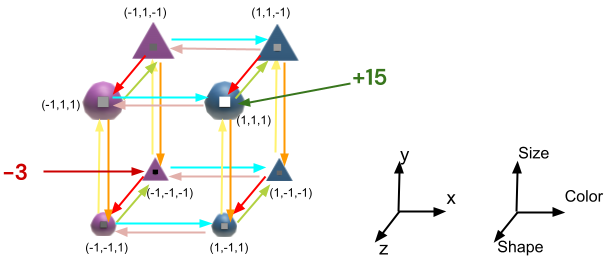

Note that the important aspects of the microprobes are independent of this exact chemistry, and the structural aspects of the task that are tested can be tested on various chemistries including ones with rotations (when the perceptual axes are not aligned with the latent axes).

---
## Put Gold Stone


Test that agents put gold stones (+15 value best stones) into cauldron, one of the simplest forms of knowledge in Alchemy.

In Trial 1: Agent presented with 3 gold stones.

Microprobe test: Pass and score +1 if agent correctly puts all 3 gold stones in the cauldron and does not use any potions.

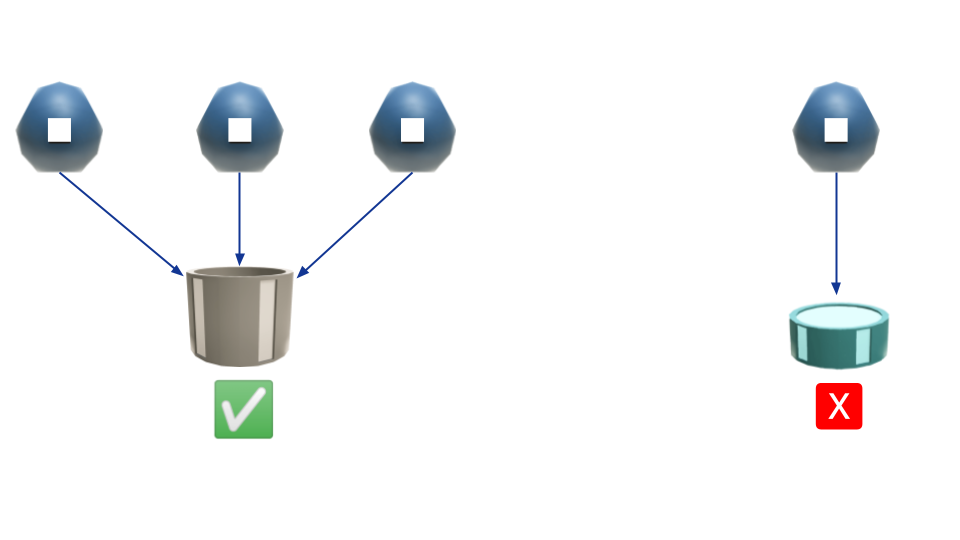

In [ ]:
#@title Put Gold Stone Class
class put_gold_stone:
  def __init__(self, add_belief_state=False):
    num_stones = 3
    mprobe_chemistry = utils.Chemistry(
      potion_map=stones_and_potions.all_fixed_potion_map(),
      stone_map=stones_and_potions.all_fixed_stone_map(),
      graph=graphs.create_graph_from_constraint(
          graphs.no_bottleneck_constraints()[0]),
      rotation=np.eye(3, dtype=np.int))
    mprobe_items = utils.EpisodeItems(
            stones=[[LatentStone(np.array([1, 1, 1], dtype=np.object))] * num_stones],
            potions=[[LatentPotion(0, -1)] * 4 + [LatentPotion(1, -1)] * 4 + [LatentPotion(2, -1)] * 4]
    )

    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
        chemistry=mprobe_chemistry, episode_items=mprobe_items)
    trackers = {
        symbolic_alchemy_trackers.AddMatrixEventTracker.NAME: 
            symbolic_alchemy_trackers.AddMatrixEventTracker(),
        symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
            symbolic_alchemy_trackers.ItemGeneratedTracker(),
        symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
            symbolic_alchemy_trackers.ItemsUsedTracker(),
        symbolic_alchemy_trackers.ScoreTracker.NAME: 
            symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
        }
    if add_belief_state:
      trackers[symbolic_alchemy_trackers.BeliefStateTracker.NAME] = symbolic_alchemy_trackers.BeliefStateTracker(precomp_maps, env)
    env.add_trackers(trackers)
    self.env = env

  def analyze_microprobe(self, episode_events):
    event_score = []
    # check that the agent puts the positive stones in the cauldron, and doesn't
    # use the potions
    target_trial_event0 = ev_trk.SingleEvent(0, {-1})
    target_trial_event1 = ev_trk.SingleEvent(1, {-1})
    target_trial_event2 = ev_trk.SingleEvent(2, {-1})
    target_happens = target_trial_event0.occurs(episode_events[0].events) and target_trial_event1.occurs(episode_events[0].events) and target_trial_event2.occurs(episode_events[0].events)
    foil_trial_events = [ev_trk.SingleEvent(0, set(range(0, 12))),
                         ev_trk.SingleEvent(1, set(range(0, 12))),
                          ev_trk.SingleEvent(2, set(range(0, 12)))]
    foil_happens = [x.occurs(episode_events[0].events) for x in foil_trial_events]
    event_score.append(int(target_happens and not any(foil_happens)))

    event_score_all = np.mean(event_score)

    return event_score_all

In [ ]:
#@title Run models through microprobe
gold_mp_scores = {}
gold_mp = put_gold_stone()
num_samples = 20
greedy = False

# model free
beta = 9
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_modelfree(gold_mp.env, beta, greedy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(gold_mp.analyze_microprobe(episode_events))
gold_mp_scores['modelfree'] = event_score

# level k
beta = 9
gamma = 0.65
for sophistication_level in range(4):
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk(gold_mp.env, beta, gamma, sophistication_level, greedy)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(gold_mp.analyze_microprobe(episode_events))
  gold_mp_scores['level'+str(sophistication_level)] = event_score

# random agent
random_policy = RandomAgent()
event_score = []
for i in range(num_samples):
  env, reward = run_mp_agent(gold_mp.env, random_policy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(gold_mp.analyze_microprobe(episode_events))
gold_mp_scores['random agent'] = event_score

# random heuristic
rh_bot = symbolic_alchemy_bots.RandomActionBot(gold_mp.env._reward_weights, gold_mp.env)
event_score = []
for i in range(num_samples):
  bot_returns = rh_bot.run_episode()
  episode_events = bot_returns['matrix_event']['event_tracker']
  event_score.append(gold_mp.analyze_microprobe(episode_events))
gold_mp_scores['random heuristic'] = event_score

# ideal observer
precomp_maps = precomputed_maps.load_from_level_name('perceptual_mapping_randomized_with_random_bottleneck') 
add_belief_state = True
gold_mp = put_gold_stone(add_belief_state)
io_bot = symbolic_alchemy_bots.IdealObserverBot(gold_mp.env._reward_weights, precomp_maps, gold_mp.env, minimise_world_states=False)
bot_returns = io_bot.run_episode()
episode_events = bot_returns['matrix_event']['event_tracker']
event_score = gold_mp.analyze_microprobe(episode_events)
gold_mp_scores['ideal observer'] = event_score

df_gold = pd.DataFrame.from_dict(gold_mp_scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] ==

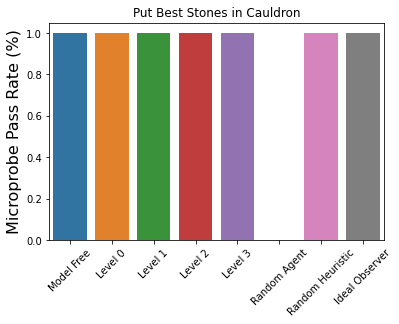

In [ ]:
#@title Plot Results
model_names = ['Model Free','Level 0','Level 1','Level 2','Level 3','Random Agent','Random Heuristic','Ideal Observer']

ax = sns.barplot(data=df_gold, ci=95)
plt.xticks(np.arange(len(model_names)), labels=model_names, rotation=45)
plt.ylabel('Microprobe Pass Rate (%)', fontsize=16)
plt.title('Put Best Stones in Cauldron')
plt.show()

We see that all the models pass this microprobe other than the random agent.

### Statistical Testing

We also provide methods to statistically test whether an agent passes the microprobe a higher percentage of times than another agent. This allows you to test an agent or model against an agent that does not possess the knowledge tested for on a microprobe. This provides a way to statistically test the null hypothesis of the agent *not* having each form of knowledge.

For this Put Gold Stone microprobe, the samples (number of passes and failures ) from 'Random Agent' will form a null binomial distribution.

Text(0.5, 1.0, 'Random Agent')

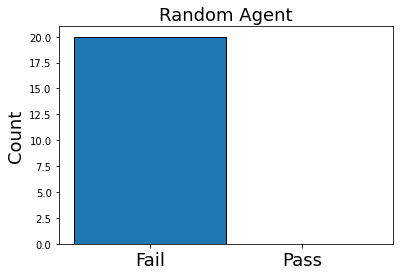

In [ ]:
#@title
plt.hist(gold_mp_scores['random agent'], bins=[0,1,2], edgecolor='black')
plt.xticks([0.5,1.5],['Fail','Pass'], fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Random Agent', fontsize=18)

We see that with 20 samples, the random agent did not pass the microprobe a single time.

We can clearly see that all the other models outperform this null distribution, and we can statistically test this with the 'compare_mp_distributions' helper function. This will output a Z-statistic and a p-value.

In [ ]:
zstat, pval = compare_mp_distributions(gold_mp_scores, 'modelfree', 'random agent', alternative='larger')
print('Z-stat %2.3f'%zstat)
print('P-value ',pval)

Z-stat 6.325
P-value  1.2698142947354283e-10


As expected, we see that the Model Free Agent performs better than the random agent at a statistically significant level P < 0.05. What about the other models?

In [ ]:
model_strings = ['modelfree','level0','level1','level2','level3','random heuristic']
zstat_list = []
reject_null = []

for model in model_strings:
  zstat, pval = compare_mp_distributions(gold_mp_scores, model, 'random agent', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)

df_stats_gold = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = model_strings)
df_stats_gold

,modelfree,level0,level1,level2,level3,random heuristic
ZStat,6.325,6.325,6.325,6.325,6.325,6.325
Reject Null,True,True,True,True,True,True


These models greatly outperform the null baseline as they pass the microprobe 100% of the time. However, a Deep RL agent may not perform as perfectly even if it propertly encodes the reward value of gold stones.

Lets use a custom agent that may work like a trained Deep RL agent, in that it possesses knowledge about the task, but it does not always express it correctly, and it sometimes takes the wrong actions due to its stochasticity.

We can do this with a Noisy Level K agent with the 'run_mp_model_levelk_plus_noise' function and toggle the probability of the agent taking a random action with the noise parameter.

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise = 0.5
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_model_levelk_plus_noise(gold_mp.env, beta, gamma, sophistication_level, greedy, noise)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(gold_mp.analyze_microprobe(episode_events))
gold_mp_scores['noisy level'+str(sophistication_level)] = event_score

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)


How often does this model pass the Put Gold Stone microprobe?

Text(0.5, 1.0, 'Noisy Level 3')

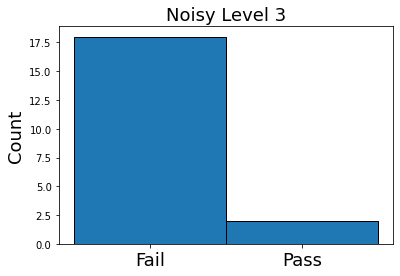

In [ ]:
#@title
plt.hist(gold_mp_scores['noisy level'+str(sophistication_level)], bins=[0,1,2], edgecolor='black')
plt.xticks([0.5,1.5],['Fail','Pass'], fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Noisy Level '+str(sophistication_level), fontsize=18)

It often fails, but it still passes more often than the random agent. Is this difference statistically significant?

In [ ]:
zstat, pval = compare_mp_distributions(gold_mp_scores, 'noisy level3', 'random agent')
print('Z-stat %2.3f'%zstat)
print('P-value ',pval)

Z-stat 1.451
P-value  0.146793087308571


We see that although the Noisy Level 3 model often fails the microprobe, it still performs statistically better (P < 0.05) than the null baseline.

We can also use the 'compare_mp_distributions' function to compare the performance of two custom agents (by comparing the two resulting binomial distributions). Lets use two Noisy Level K agents with different levels of noise (0.1 and 0.5) as a proxy for this. We use a two-sided test here (alternative='two-sided') to test if the two distributions are different without a hypothesis about direction.

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.5]
for noise in noise_levels:
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk_plus_noise(gold_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(gold_mp.analyze_microprobe(episode_events))
  gold_mp_scores['level3 noise_'+str(noise)] = event_score
  print('Microprobe Pass Rate, level3 noise_'+str(noise)+':',np.mean(event_score))

zstat, pval = compare_mp_distributions(gold_mp_scores, 'level3 noise_0.1', 'level3 noise_0.5', alternative='two-sided')
print('Z-stat %2.3f'%zstat)
print('P-value ',pval)

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)


Microprobe Pass Rate, level3 noise_0.1: 0.8
Microprobe Pass Rate, level3 noise_0.5: 0.15
Z-stat 4.116
P-value  3.853216070737727e-05


We see a significant difference between the agents. We can also increase the statistical power by increasing the number of samples that the agents run the microprobe to 200.

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.5]
for noise in noise_levels:
  event_score = []
  for i in range(200):
    env, traj, reward = run_mp_model_levelk_plus_noise(gold_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(gold_mp.analyze_microprobe(episode_events))
  gold_mp_scores['level3 noise_'+str(noise)] = event_score
  print('Microprobe Pass Rate, level3 noise_'+str(noise)+':',np.mean(event_score))

zstat, pval = compare_mp_distributions(gold_mp_scores, 'level3 noise_0.1', 'level3 noise_0.5', alternative='two-sided')
print('Z-stat %2.3f'%zstat)
print('P-value ',pval)

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)


Microprobe Pass Rate, level3 noise_0.1: 0.815
Microprobe Pass Rate, level3 noise_0.5: 0.215
Z-stat 12.005
P-value  3.3283600865185284e-33


By increasing the sample size, we see a larger Z-statistic and smaller p-value.

Let's also compare other noise levels to the random agent

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
for noise in noise_levels:
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk_plus_noise(gold_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(gold_mp.analyze_microprobe(episode_events))
  gold_mp_scores['level3 noise_'+str(noise)] = event_score

zstat_list = []
reject_null = []
keys = []

for noise in noise_levels:
  key = 'level3 noise_'+str(noise)
  zstat, pval = compare_mp_distributions(gold_mp_scores, key, 'random agent', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)
  keys.append(key)

df_stats_gold_noise = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = keys)
df_stats_gold_noise

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
ZStat,5.721,3.162,1.451,1.013,0.0
Reject Null,True,True,False,False,False


We see that as the noise level increases, the Z-statistic decreases and the agent eventually performs poor enough to fail to reject the null hypothesis that the agent does not have the knowledge required to pass All Value Stones above chance level.

---
## All Value Stones


Test that agents only put positive stones into cauldron.

Trial 1: Agent presented with 1 +15 goldstone, 1 +1 stone, 1 -1 stone, and 12
potions that have no effect.

Trial 2: Agent presented with 1 +1 stone, 1 -1 stone, 1 -3 stone, and 12
potions that either have no effect or can't make a positive stone.

Microprobe test: Pass and score +1 if agent puts positive stones in the cauldron, and doesn't put the negative stones in the cauldron

**This assesses whether an agent understands the reward values of the different stones.**

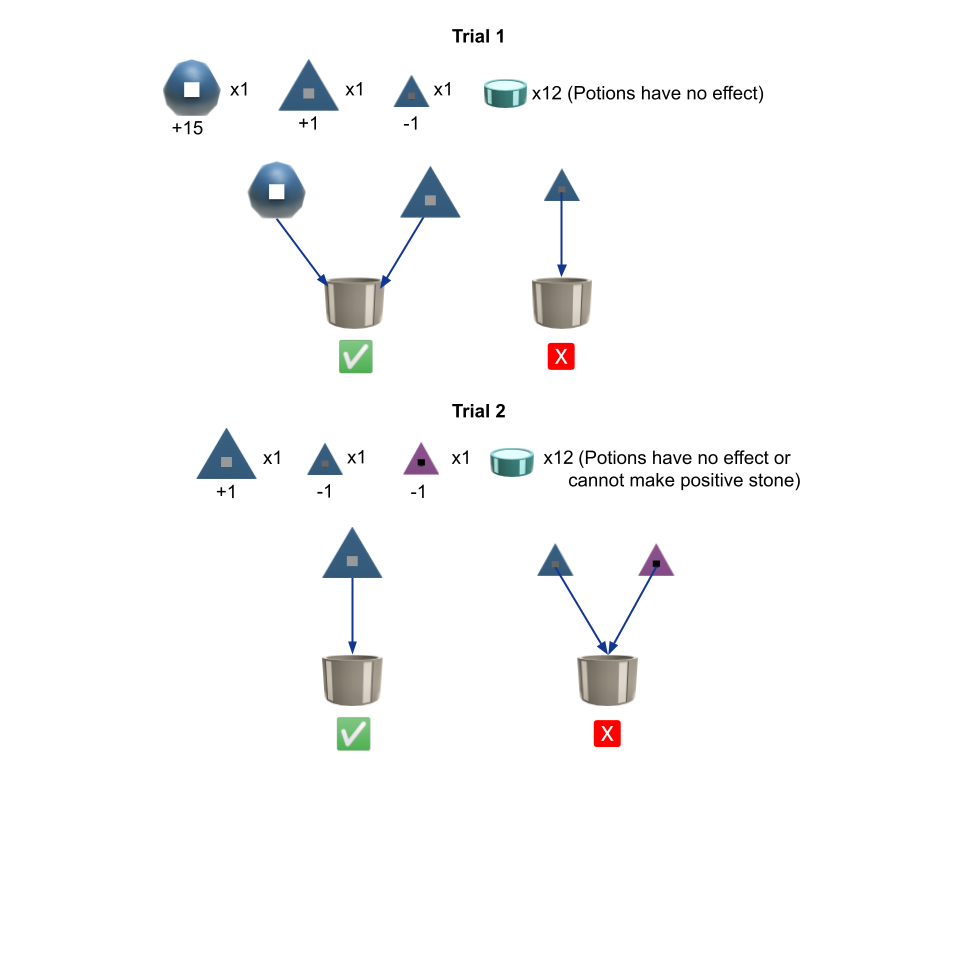

In [ ]:
#@title All Value Stones Class
class all_value_stones:
  def __init__(self, add_belief_state=False):
    mprobe_chemistry = utils.Chemistry(
      potion_map=stones_and_potions.all_fixed_potion_map(),
      stone_map=stones_and_potions.all_fixed_stone_map(),
      graph=graphs.create_graph_from_constraint(
          graphs.no_bottleneck_constraints()[0]),
      rotation=np.eye(3, dtype=np.int))
    mprobe_items = utils.EpisodeItems(
            stones=[
                [LatentStone(np.array([1, 1, 1], dtype=np.object)),
                LatentStone(np.array([1, 1, -1], dtype=np.object)),
                LatentStone(np.array([1, -1, -1], dtype=np.object))],
                [LatentStone(np.array([1, 1, -1], dtype=np.object)),
                LatentStone(np.array([1, -1, -1], dtype=np.object)),
                LatentStone(np.array([-1, -1, -1], dtype=np.object))]
            ],
            potions=[
                [LatentPotion(0, 1)] * 12] * 2)

    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
        chemistry=mprobe_chemistry, episode_items=mprobe_items)
    trackers = {
        symbolic_alchemy_trackers.AddMatrixEventTracker.NAME: 
            symbolic_alchemy_trackers.AddMatrixEventTracker(),
        symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
            symbolic_alchemy_trackers.ItemGeneratedTracker(),
        symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
            symbolic_alchemy_trackers.ItemsUsedTracker(),
        symbolic_alchemy_trackers.ScoreTracker.NAME: 
            symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
        }
    if add_belief_state:
      trackers[symbolic_alchemy_trackers.BeliefStateTracker.NAME] = symbolic_alchemy_trackers.BeliefStateTracker(precomp_maps, env)
    env.add_trackers(trackers)
    self.env = env

  def analyze_microprobe(self, episode_events):
    event_score = []
    # check that the agent puts the positive stones in the cauldron, and doesn't
    # put the negative stones in the cauldron

    # Trial 1
    target_trial_event = ev_trk.AnyOrderEvents(
        {ev_trk.SingleEvent(0, {-1}), ev_trk.SingleEvent(1, {-1})})
    target_happens = target_trial_event.occurs(episode_events[0].events)
    foil_trial_event = ev_trk.SingleEvent(2, {-1})
    foil_happens = foil_trial_event.occurs(episode_events[0].events)
    event_score.append(int(target_happens and not foil_happens))

    # Trial 2
    target_trial_event = ev_trk.SingleEvent(0, {-1})
    target_happens = target_trial_event.occurs(episode_events[1].events)
    foil_trial_events = [ev_trk.SingleEvent(1, {-1}),
                          ev_trk.SingleEvent(2, {-1})]
    foil_happens = [x.occurs(episode_events[1].events) for x in foil_trial_events]
    event_score.append(int(target_happens and not any(foil_happens)))

    event_score_all = int(sum(event_score) == 2)

    return event_score_all

In [ ]:
#@title Run models through microprobe
avs_mp_scores = {}
all_value_mp = all_value_stones()
num_samples = 20
greedy = False

# model free
beta = 9
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_modelfree(all_value_mp.env, beta)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(all_value_mp.analyze_microprobe(episode_events))
avs_mp_scores['modelfree'] = event_score

# level k
beta = 9
gamma = 0.65
for sophistication_level in range(4):
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk(all_value_mp.env, beta, gamma, sophistication_level, greedy)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(all_value_mp.analyze_microprobe(episode_events))
  avs_mp_scores['level'+str(sophistication_level)] = event_score

# random agent
random_policy = RandomAgent()
event_score = []
for i in range(num_samples):
  env, reward = run_mp_agent(all_value_mp.env, random_policy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(all_value_mp.analyze_microprobe(episode_events))
avs_mp_scores['random agent'] = event_score

# random heuristic
rh_bot = symbolic_alchemy_bots.RandomActionBot(all_value_mp.env._reward_weights, all_value_mp.env)
event_score = []
for i in range(num_samples):
  bot_returns = rh_bot.run_episode()
  episode_events = bot_returns['matrix_event']['event_tracker']
  event_score.append(all_value_mp.analyze_microprobe(episode_events))
avs_mp_scores['random heuristic'] = event_score

# ideal observer
add_belief_state = True
all_value_mp = all_value_stones(add_belief_state)
io_bot = symbolic_alchemy_bots.IdealObserverBot(all_value_mp.env._reward_weights, precomp_maps, all_value_mp.env, minimise_world_states=False)
bot_returns = io_bot.run_episode()
episode_events = bot_returns['matrix_event']['event_tracker']
event_score = all_value_mp.analyze_microprobe(episode_events)
avs_mp_scores['ideal observer'] = event_score

df_avs = pd.DataFrame.from_dict(data=avs_mp_scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python

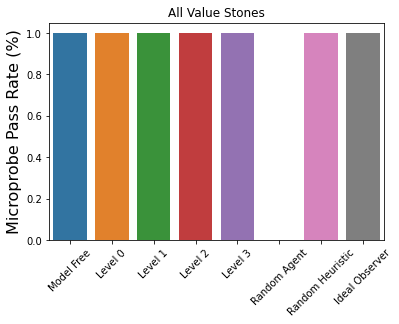

In [ ]:
#@title Plot Results
model_names = ['Model Free','Level 0','Level 1','Level 2','Level 3','Random Agent','Random Heuristic','Ideal Observer']

ax = sns.barplot(data=df_avs)
plt.xticks(np.arange(len(model_names)), labels=model_names, rotation=45)
plt.ylabel('Microprobe Pass Rate (%)', fontsize=16)
plt.title('All Value Stones')
plt.show()

We see that the models that encode the meaning of the stone values pass this microprobe. The random agent passes by chance on the rare occassion.

### Statistical Testing

How do the other models compare to this chance performance level?

In [ ]:
#@title
model_strings = ['modelfree','level0','level1','level2','level3','random heuristic']
zstat_list = []
reject_null = []

for model in model_strings:
  zstat, pval = compare_mp_distributions(avs_mp_scores, model, 'random agent', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)

df_stats_avs = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = model_strings)
df_stats_avs

,modelfree,level0,level1,level2,level3,random heuristic
ZStat,6.325,6.325,6.325,6.325,6.325,6.325
Reject Null,True,True,True,True,True,True


Unsurprisingly, they all outperformed the null model 

How about a sophisticated model with various levels of noise?

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
for noise in noise_levels:
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk_plus_noise(all_value_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(all_value_mp.analyze_microprobe(episode_events))
  avs_mp_scores['level3 noise_'+str(noise)] = event_score

zstat_list = []
reject_null = []
keys = []

for noise in noise_levels:
  key = 'level3 noise_'+str(noise)
  zstat, pval = compare_mp_distributions(avs_mp_scores, key, 'random agent', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)
  keys.append(key)

df_stats_avs_noise = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = keys)
df_stats_avs_noise

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)


,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
ZStat,5.437,4.899,3.162,2.39,1.451
Reject Null,True,True,True,True,False


Just as in Put Gold Stone, we see that as the noise level increases, the Z-statistic decreases and the agent eventually performs poor enough to fail to reject the null hypothesis that the agent does not have the knowledge required to pass All Value Stones above chance level.

---
## Avoid Bad Potions

Test that agents don't use potions that turn a stone negative.

Trial 1: Agent presented with three +1 stones and 12 potions that take these
stones to -1.

Trial 2: Same stones/potions as trial 1.

Microprobe test: Pass and score +1 if on Trial 2 agent puts stones in the cauldron and avoids using the bad potions

Can take an argument mixed_types, which determines whether there are
different types of stones/potions, or if they're all identical.

**This microprobe tests for an agent's ability to refrain from putting stones in potions if those potions reduce the value of the stone. Additionally, this assesses whether an agent can learn from experience in an episode, because after observing a bad transformation on the first trial, an agent must not use that potion on the second trial.**

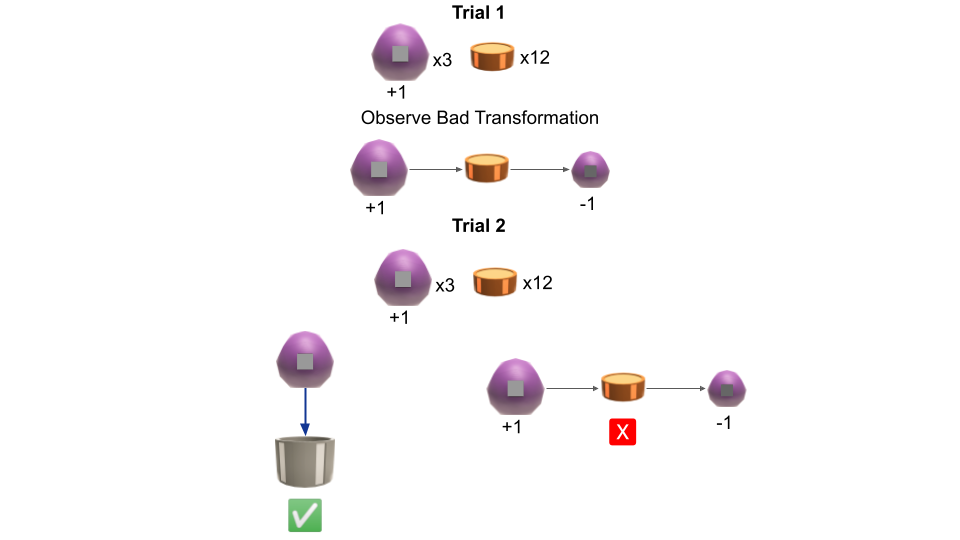

In [ ]:
#@title Avoid Bad Potions Class
class avoid_bad_potions():
  def __init__(self, mixed_types = False, add_belief_state=False):

    if mixed_types:
      init_stones = [LatentStone(np.array([-1, 1, 1], dtype=np.object)),
                      LatentStone(np.array([1, -1, 1], dtype=np.object)),
                      LatentStone(np.array([1, 1, -1], dtype=np.object))]
      init_potions = [LatentPotion(0, -1)] * 4 + [LatentPotion(1, -1)] * 4 \
          + [LatentPotion(2, -1)] * 4
      # If types match, potion doesn't have any effect
      self.stone_type_mapping = {0: 0, 1: 1, 2: 2}
      self.potion_type_mapping = {x: x // 4 for x in range(12)}
    else:
      init_stones = [LatentStone(np.array([-1, 1, 1], dtype=np.object))] * 3
      init_potions = [LatentPotion(1, -1)] * 12
      self.stone_type_mapping = {x: 0 for x in range(3)}
      self.potion_type_mapping = {x: 1 for x in range(12)}

    mprobe_chemistry = utils.Chemistry(
        potion_map=stones_and_potions.all_fixed_potion_map(),
        stone_map=stones_and_potions.all_fixed_stone_map(),
        graph=graphs.create_graph_from_constraint(
            graphs.no_bottleneck_constraints()[0]),
        rotation=np.eye(3, dtype=np.int))
    mprobe_items = utils.EpisodeItems(
        stones=[init_stones] * 2,
        potions=[init_potions] * 2)
    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
        chemistry=mprobe_chemistry, episode_items=mprobe_items)
    trackers = {
        symbolic_alchemy_trackers.AddMatrixEventTracker.NAME: 
            symbolic_alchemy_trackers.AddMatrixEventTracker(),
        symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
            symbolic_alchemy_trackers.ItemGeneratedTracker(),
        symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
            symbolic_alchemy_trackers.ItemsUsedTracker(),
        symbolic_alchemy_trackers.ScoreTracker.NAME: 
            symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
        }
    if add_belief_state:
      trackers[symbolic_alchemy_trackers.BeliefStateTracker.NAME] = symbolic_alchemy_trackers.BeliefStateTracker(precomp_maps, env)
    env.add_trackers(trackers)
    self.env = env

  def analyze_microprobe(self, episode_events):
    event_score = []
    # For Trial 2 - check that the agent puts the positive stones in the cauldron, and doesn't
    # use the potions
    target_trial_event0 = ev_trk.SingleEvent(0, {-1})
    target_trial_event1 = ev_trk.SingleEvent(1, {-1})
    target_trial_event2 = ev_trk.SingleEvent(2, {-1})
    target_happens = target_trial_event0.occurs(episode_events[1].events) and target_trial_event1.occurs(episode_events[1].events) and target_trial_event2.occurs(episode_events[1].events)
    foil_trial_events = [ev_trk.SingleEvent(0, set(range(0, 12))),
                         ev_trk.SingleEvent(1, set(range(0, 12))),
                          ev_trk.SingleEvent(2, set(range(0, 12)))]
    foil_happens = [x.occurs(episode_events[1].events) for x in foil_trial_events]
    event_score.append(int(target_happens and not any(foil_happens)))

    event_score_all = np.mean(event_score)

    return event_score_all


In [ ]:
#@title Run models through microprobe
abp_mp_scores = {}
mixed_types = False
abp_mp = avoid_bad_potions(mixed_types)
num_samples = 20
greedy = False

#model free
beta = 9
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_modelfree(abp_mp.env, beta, greedy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(abp_mp.analyze_microprobe(episode_events))
abp_mp_scores['modelfree'] = event_score

#level k
beta = 9
gamma = 0.65
for sophistication_level in range(4):
  event_score = []
  for i in range(num_samples):  
    env, traj, reward = run_mp_model_levelk(abp_mp.env, beta, gamma, sophistication_level, greedy)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(abp_mp.analyze_microprobe(episode_events))
  abp_mp_scores['level'+str(sophistication_level)] = event_score

# random agent
random_policy = RandomAgent()
event_score = []
for i in range(num_samples):
  env, reward = run_mp_agent(abp_mp.env, random_policy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(abp_mp.analyze_microprobe(episode_events))
abp_mp_scores['random agent'] = event_score

# random heuristic
rh_bot = symbolic_alchemy_bots.RandomActionBot(abp_mp.env._reward_weights, abp_mp.env)
event_score = []
for i in range(num_samples):
  bot_returns = rh_bot.run_episode()
  episode_events = bot_returns['matrix_event']['event_tracker']
  event_score.append(abp_mp.analyze_microprobe(episode_events))
abp_mp_scores['random heuristic'] = event_score

#ideal observer
abp_mp = avoid_bad_potions(mixed_types = False, add_belief_state = True)
io_bot = symbolic_alchemy_bots.IdealObserverBot(abp_mp.env._reward_weights, precomp_maps, abp_mp.env, minimise_world_states=False)
bot_returns = io_bot.run_episode()
episode_events = bot_returns['matrix_event']['event_tracker']
event_score = abp_mp.analyze_microprobe(episode_events)
abp_mp_scores['ideal observer'] = event_score

df_abp = pd.DataFrame.from_dict(data=abp_mp_scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal

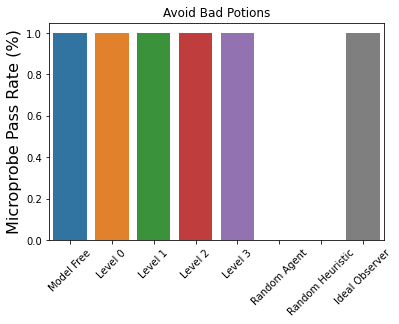

In [ ]:
#@title Plot Results
model_names = ['Model Free','Level 0','Level 1','Level 2','Level 3','Random Agent','Random Heuristic','Ideal Observer']

ax = sns.barplot(data=df_abp)
plt.xticks(np.arange(len(model_names)), labels=model_names, rotation=45)
plt.ylabel('Microprobe Pass Rate (%)', fontsize=16)
plt.title('Avoid Bad Potions')
plt.show()

The models that have a capacity to learn within episode passed this microprobe. Since both the random agent and random heuristic do not learn, they do not refrain from using the bad potion. Additionally, feedforward RL agents without memory will tend to fail this microprobe as they do not have the ability to quickly adapt their policy based on the history of observations in an episode.

### Statistical Testing

How do the other models compare to the chance performance level of the random agent?

In [ ]:
#@title
model_strings = ['modelfree','level0','level1','level2','level3','random heuristic']
zstat_list = []
reject_null = []

for model in model_strings:
  zstat, pval = compare_mp_distributions(abp_mp_scores, model, 'random agent', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)

df_stats_abp = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = model_strings)
df_stats_abp

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,modelfree,level0,level1,level2,level3,random heuristic
ZStat,6.325,6.325,6.325,6.325,6.325,0.0
Reject Null,True,True,True,True,True,False


As expected, the models that learn statistically outperform the null model (random agent) and the random heuristic does not.

How about a sophisticated model with various levels of noise?

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
for noise in noise_levels:
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk_plus_noise(abp_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(abp_mp.analyze_microprobe(episode_events))
  abp_mp_scores['level3 noise_'+str(noise)] = event_score

zstat_list = []
reject_null = []
keys = []

for noise in noise_levels:
  key = 'level3 noise_'+str(noise)
  zstat, pval = compare_mp_distributions(abp_mp_scores, key, 'random agent', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)
  keys.append(key)

df_stats_abp_noise = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = keys)
df_stats_abp_noise

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)


,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
ZStat,4.899,3.408,2.657,1.451,1.013
Reject Null,True,True,True,False,False


---
## Potion Effect Same Stone

Test if an agent can learn about a potion's effect on a stone in one trial and correctly apply that potion to the same stone on the next trial.

1.   Trial 1: present the best stone so agent can observe that this is the best stone, paired with 12 potions which have no effect in order to learn what the best stone is.
2.   Trial 2: present a +1 reward stone, and 12 of the same potion type, which can turn it into the +15 reward best stone by transforming one dimension.
3.   Trial 3: present the same +1 reward stone, and 6 of the same potion type from the last trial, along with 6 of another potion type that has not been observed and has no effect.

Microprobe test: Pass and score +1 if agent uses correct potion immediately on stones in Trial 3 and avoids using the new potion

**This microprobe tests if an agent can learn within an episode, which requires a memory system.**


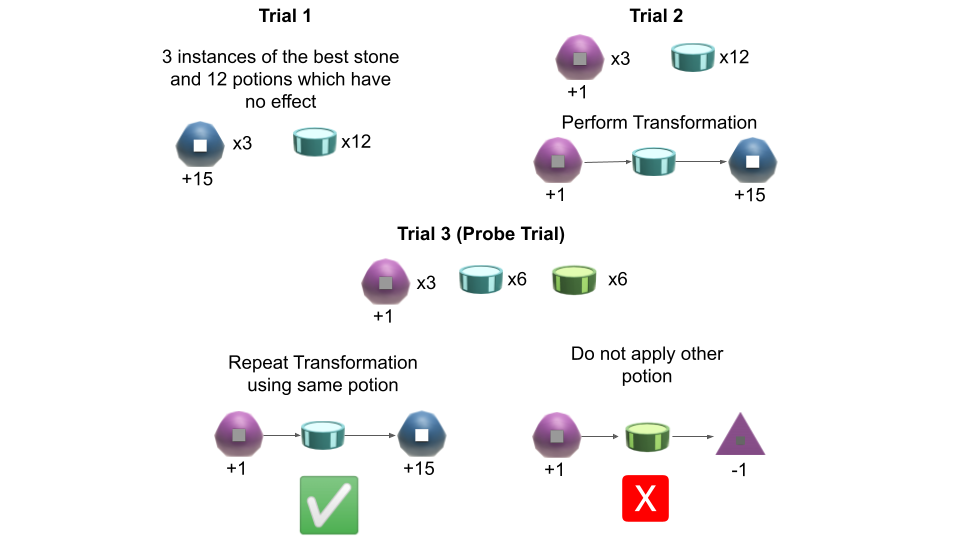

In [ ]:
#@title Potion Effect Same Stone Class
class potion_effect_same_stone:
  def __init__(self, add_belief_state=False):
    LatentPotion = stones_and_potions.LatentPotion
    LatentStone = stones_and_potions.LatentStone
    num_stones = 3

    mprobe_chemistry = utils.Chemistry(
      potion_map=stones_and_potions.all_fixed_potion_map(),
      stone_map=stones_and_potions.all_fixed_stone_map(),
      graph=graphs.create_graph_from_constraint(
          graphs.no_bottleneck_constraints()[0]),
      rotation=np.eye(3, dtype=np.int))
    mprobe_items = utils.EpisodeItems(
    stones=[
        [LatentStone(np.array([1, 1, 1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([-1, 1, 1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([-1, 1, 1], dtype=np.object))] * num_stones
    ],
    potions=[
        [LatentPotion(0, 1)] * 12,
        [LatentPotion(0, 1)] * 12,
        [LatentPotion(0, 1)] * 6 + [LatentPotion(2, -1)] * 6
    ])

    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
        chemistry=mprobe_chemistry, episode_items=mprobe_items)
    trackers = {
          symbolic_alchemy_trackers.AddMatrixEventTracker.NAME: 
              symbolic_alchemy_trackers.AddMatrixEventTracker(),
          symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
              symbolic_alchemy_trackers.ItemGeneratedTracker(),
          symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
              symbolic_alchemy_trackers.ItemsUsedTracker(),
          symbolic_alchemy_trackers.ScoreTracker.NAME: 
              symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
          }
    if add_belief_state:
      trackers[symbolic_alchemy_trackers.BeliefStateTracker.NAME] = symbolic_alchemy_trackers.BeliefStateTracker(precomp_maps, env)
    env.add_trackers(trackers)
    self.env = env

  def analyze_microprobe(self, episode_events):
    # check that on the third trial, the first potion type is used on all
    # stones, and the stones are then placed into the cauldron
    target_trial_event0 = ev_trk.OrderedEvents(
        [ev_trk.SingleEvent(0, set(range(6))),
          ev_trk.SingleEvent(0, {-1})])
    target_trial_event1 = ev_trk.OrderedEvents(
        [ev_trk.SingleEvent(1, set(range(6))),
          ev_trk.SingleEvent(1, {-1})])
    target_trial_event2 = ev_trk.OrderedEvents(
        [ev_trk.SingleEvent(2, set(range(6))),
          ev_trk.SingleEvent(2, {-1})])
    target_happens = target_trial_event0.occurs(episode_events[2].events) and target_trial_event1.occurs(episode_events[2].events) and target_trial_event2.occurs(episode_events[2].events)
    
    # check that it does NOT use the other potion type
    foil_trial_event0 = ev_trk.SingleEvent(0, set(range(6, 12)))
    foil_trial_event1 = ev_trk.SingleEvent(1, set(range(6, 12)))
    foil_trial_event2 = ev_trk.SingleEvent(2, set(range(6, 12)))
    foil_happens = foil_trial_event0.occurs(episode_events[2].events) or foil_trial_event1.occurs(episode_events[2].events) or foil_trial_event2.occurs(episode_events[2].events)
    event_score = int(target_happens and not foil_happens)

    return event_score

In [ ]:
#@title Run models through microprobe
pess_mp_scores = {}
pess_mp = potion_effect_same_stone()
num_samples = 20
greedy = False

#model free
beta = 9
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_modelfree(pess_mp.env, beta, greedy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(pess_mp.analyze_microprobe(episode_events))
pess_mp_scores['modelfree'] = event_score

#level k
beta = 9
gamma = 0.65
for sophistication_level in range(4):
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk(pess_mp.env, beta, gamma, sophistication_level, greedy)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(pess_mp.analyze_microprobe(episode_events))
  pess_mp_scores['level'+str(sophistication_level)] = event_score

# random agent
random_policy = RandomAgent()
event_score = []
for i in range(num_samples):
  env, reward = run_mp_agent(pess_mp.env, random_policy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(pess_mp.analyze_microprobe(episode_events))
pess_mp_scores['random agent'] = event_score

#random heuristic
rh_bot = symbolic_alchemy_bots.RandomActionBot(pess_mp.env._reward_weights, pess_mp.env)
event_score = []
for i in range(num_samples):
  bot_returns = rh_bot.run_episode()
  episode_events = bot_returns['matrix_event']['event_tracker']
  event_score.append(pess_mp.analyze_microprobe(episode_events))
pess_mp_scores['random heuristic'] = event_score

#ideal observer
add_belief_state = True
pess_mp = potion_effect_same_stone(add_belief_state)
io_bot = symbolic_alchemy_bots.IdealObserverBot(pess_mp.env._reward_weights, precomp_maps, pess_mp.env, minimise_world_states=False)
bot_returns = io_bot.run_episode()
episode_events = bot_returns['matrix_event']['event_tracker']
event_score = pess_mp.analyze_microprobe(episode_events)
pess_mp_scores['ideal observer'] = event_score

df_pess = pd.DataFrame.from_dict(data=pess_mp_scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/di

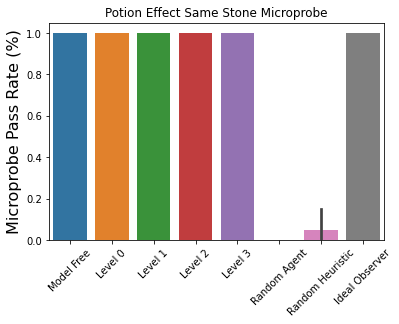

In [ ]:
#@title Plot Results
model_names = ['Model Free','Level 0','Level 1','Level 2','Level 3','Random Agent','Random Heuristic','Ideal Observer']

ax = sns.barplot(data=df_pess)
plt.xticks(np.arange(len(model_names)), labels=model_names, rotation=45)
plt.ylabel('Microprobe Pass Rate (%)', fontsize=16)
plt.title('Potion Effect Same Stone Microprobe')
plt.show()

Similarly to the Avoid Bad Potions microprobe, the models that have a capacity to learn within episode passed this microprobe. Purely feedforward RL agents will not be able to retain the knowledge learned on the 2nd trial in order to repeat the transformations on the 3rd trial.

### Statistical Testing

On the microprobes, we want to compare against against the best model that does not encode the knowledge being tested for. This gives us the best estimate of what chance level performance is for the models that pass lower level microprobes but not the current one. For Potion Effect Same Stone, the random heuristic can pass by chance if it randomly puts the stones in the current potion because it will then correctly put the new gold stones in the cauldron. Therefore, we use the random heuristic as the null baseline here rather than the random agent. 

How do the other models compare to the chance performance level of the null baseline? 

In [ ]:
#@title
model_strings = ['modelfree','level0','level1','level2','level3','random agent']
zstat_list = []
reject_null = []

for model in model_strings:
  zstat, pval = compare_mp_distributions(pess_mp_scores, model, 'random heuristic', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)

df_stats_pess = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = model_strings)
df_stats_pess

,modelfree,level0,level1,level2,level3,random agent
ZStat,6.016,6.016,6.016,6.016,6.016,-1.013
Reject Null,True,True,True,True,True,False


As expected, the models that learn statistically outperform the new null model (random heuristic).

How about a sophisticated model with various levels of noise?

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
for noise in noise_levels:
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk_plus_noise(pess_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(pess_mp.analyze_microprobe(episode_events))
  pess_mp_scores['level3 noise_'+str(noise)] = event_score

zstat_list = []
reject_null = []
keys = []

for noise in noise_levels:
  key = 'level3 noise_'+str(noise)
  zstat, pval = compare_mp_distributions(pess_mp_scores, key, 'random heuristic', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)
  keys.append(key)

df_stats_pess_noise = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = keys)
df_stats_pess_noise

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)


,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
ZStat,3.978,2.921,0.0,-1.013,-1.013
Reject Null,True,True,False,False,False


---
## One Shot Learning

One trial, observe if agent can learn in one shot about potion effect and its opposite. 

Agent tested if it immediately repeats the transformation Stone(-1, 1, 1) -> Potion(0, 1) = Stone(1, 1, 1) after it first observes it.

Microprobe test: Pass and score +1 if agent uses the same potion again within two steps after it first observes its function.

**This microprobe tests if an agent can learn within an episode in one shot. It also tests for generalization across stone and potion instances. If an agent understands that the same stones or potions can be present in different slots, it will be able to observe the transformation of the stone in the first slot and understand it can apply the same transformation to an identical stone in the second slot. This type of generalization may be trivial for a human that understands the abstractions of Alchemy, but it is far from trivial for a deep RL agent that receives observations in a vector form.**

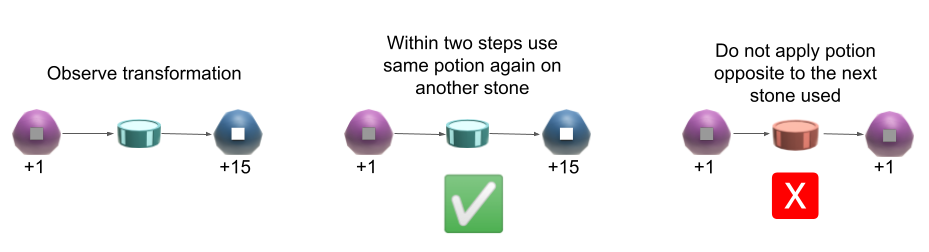

In [ ]:
#@title One Shot Learning Class
# one trial, observe if agent can learn in one shot about potion effect and its opposite

class one_shot_learning:
  def __init__(self, add_belief_state=False):
    LatentPotion = stones_and_potions.LatentPotion
    LatentStone = stones_and_potions.LatentStone

    mprobe_chemistry = utils.Chemistry(
      potion_map=stones_and_potions.all_fixed_potion_map(),
      stone_map=stones_and_potions.all_fixed_stone_map(),
      graph=graphs.create_graph_from_constraint(
          graphs.no_bottleneck_constraints()[0]),
      rotation=np.eye(3, dtype=np.int))
    mprobe_items = utils.EpisodeItems(
    stones=[
        [LatentStone(np.array([-1, 1, 1], dtype=np.object)),
        LatentStone(np.array([-1, 1, 1], dtype=np.object)),
        LatentStone(np.array([-1, 1, -1], dtype=np.object))]
    ],
    potions=[
        [LatentPotion(0, 1)] * 4 + [LatentPotion(0, -1)] * 8
    ])

    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
        chemistry=mprobe_chemistry, episode_items=mprobe_items)
    trackers = {
          symbolic_alchemy_trackers.AddMatrixEventTracker.NAME: 
              symbolic_alchemy_trackers.AddMatrixEventTracker(),
          symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
              symbolic_alchemy_trackers.ItemGeneratedTracker(),
          symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
              symbolic_alchemy_trackers.ItemsUsedTracker(),
          symbolic_alchemy_trackers.ScoreTracker.NAME: 
              symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
          }
    if add_belief_state:
      trackers[symbolic_alchemy_trackers.BeliefStateTracker.NAME] = symbolic_alchemy_trackers.BeliefStateTracker(precomp_maps, env)
    env.add_trackers(trackers)
    self.env = env

  def analyze_microprobe(self, episode_events):
    trial_events = episode_events[0].events
    target_potion_step = -1
    num_steps = np.max(trial_events) + 1
    for step in range(num_steps):
      # find the step when the agent first samples the target stone potion transformation
      step_event = np.where(trial_events == step)
      if step_event[0] < 2 and step_event[1] < 4:
        target_potion_step = step
        target_stone_used = step_event[0]
        break

    if target_potion_step == -1:
      # if agent never uses target potion, microprobe is failed
      event_score = 0
      return event_score

    for step_after in range(1,3):
      # identify what happens in the next two steps
      temp_step = target_potion_step + step_after
      step_event = np.where(trial_events == temp_step)
      if step_event[0] == target_stone_used and step_event[1] == 12:
        # cauldron action continue to next step
        continue

      if step_event[0] != target_stone_used and step_event[1] < 4:
        # agent correctly applied same potion to another stone
        target_happens = True
        break
      else:
        # agent did not apply same potion to another stone
        target_happens = False

    event_score = int(target_happens)

    return event_score

In [ ]:
#@title Run models through microprobe
one_shot_mp_scores = {}
one_shot_mp = one_shot_learning()
num_samples = 20
greedy = False

#model free
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_modelfree(one_shot_mp.env, beta, greedy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(one_shot_mp.analyze_microprobe(episode_events))
one_shot_mp_scores['modelfree'] = event_score

#level k
for sophistication_level in range(4):
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk(one_shot_mp.env, beta, gamma, sophistication_level, greedy)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(one_shot_mp.analyze_microprobe(episode_events))
  one_shot_mp_scores['level'+str(sophistication_level)] = event_score

# random agent
random_policy = RandomAgent()
event_score = []
for i in range(num_samples):
  env, reward = run_mp_agent(one_shot_mp.env, random_policy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(one_shot_mp.analyze_microprobe(episode_events))
one_shot_mp_scores['random agent'] = event_score

#random heuristic
rh_bot = symbolic_alchemy_bots.RandomActionBot(one_shot_mp.env._reward_weights, one_shot_mp.env)
event_score = []
for i in range(num_samples):
  bot_returns = rh_bot.run_episode()
  episode_events = bot_returns['matrix_event']['event_tracker']
  event_score.append(one_shot_mp.analyze_microprobe(episode_events))
one_shot_mp_scores['random heuristic'] = event_score

#ideal observer
add_belief_state = True
one_shot_mp = one_shot_learning(add_belief_state)
io_bot = symbolic_alchemy_bots.IdealObserverBot(one_shot_mp.env._reward_weights, precomp_maps, one_shot_mp.env, minimise_world_states=False)
bot_returns = io_bot.run_episode()
episode_events = bot_returns['matrix_event']['event_tracker']
event_score = one_shot_mp.analyze_microprobe(episode_events)
one_shot_mp_scores['ideal observer'] = event_score

df_one_shot = pd.DataFrame.from_dict(data=one_shot_mp_scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: Depre

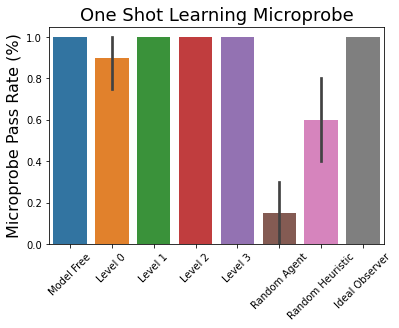

In [ ]:
#@title Plot Results
model_names = ['Model Free','Level 0','Level 1','Level 2','Level 3','Random Agent','Random Heuristic','Ideal Observer']

ax = sns.barplot(data=df_one_shot)
plt.xticks(np.arange(len(model_names)), labels=model_names, rotation=45)
plt.ylabel('Microprobe Pass Rate (%)', fontsize=16)
plt.title('One Shot Learning Microprobe', fontsize=18)
plt.show()

Just as in Avoid Bad Potions and Potion Effect Same Stone, the models that have a capacity to learn within an episode pass this microprobe. Learning occurs in one shot because the model free agent has a learning rate of 1, and the model based agents immediately update their knowledge about potion effects when they are observed. Additionally, this shows that the models have the ability to generalize across instances. This structure was built into the models directly, but must be learned de novo by deep RL agents.

### Statistical Testing

How do the other models compare to the chance performance level of the null baseline? Again we use the random heuristic as the null baseline rather than the random agent to provide the best comparison against the chance level of an agent without the inductive bias required for One Shot Learning.

In [ ]:
#@title
model_strings = ['modelfree','level0','level1','level2','level3','random agent']
zstat_list = []
reject_null = []

for model in model_strings:
  zstat, pval = compare_mp_distributions(one_shot_mp_scores, model, 'random heuristic', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)

df_stats_one_shot = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = model_strings)
df_stats_one_shot

,modelfree,level0,level1,level2,level3,random agent
ZStat,3.162,2.191,3.162,3.162,3.162,-2.939
Reject Null,True,True,True,True,True,False


As expected, the models that learn statistically outperform the null model (random heuristic).

How about a sophisticated model with various levels of noise?

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
for noise in noise_levels:
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk_plus_noise(one_shot_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(one_shot_mp.analyze_microprobe(episode_events))
  one_shot_mp_scores['level3 noise_'+str(noise)] = event_score

zstat_list = []
reject_null = []
keys = []

for noise in noise_levels:
  key = 'level3 noise_'+str(noise)
  zstat, pval = compare_mp_distributions(one_shot_mp_scores, key, 'random heuristic', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)
  keys.append(key)

df_stats_one_shot_noise = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = keys)
df_stats_one_shot_noise

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
ZStat,3.162,1.771,0.327,0.663,-1.265
Reject Null,True,True,False,False,False


---
## Potion Effect Different Stone

Test using a learned potion effect on different stone.

1.   Trial 1: present the best stone, and 12 potions which have no effect in order to learn what the best stone is.
2.   Trial 2: present a -1 reward stone, and 12 of the same potion type, which can turn it into a +1 reward stone along by transforming one dimension.
3.   Trial 3: present a new stone that can be turned into the best stone using the same potion used in the last trial, and another potion that is new and has no effect (6 each to give 12 total potions)

Microprobe test: Pass and score +1 if agent uses correct potion on new stone and avoids using new potion

**This microprobe tests for the generalization of knowledge about a potion's effect to a new stone.**

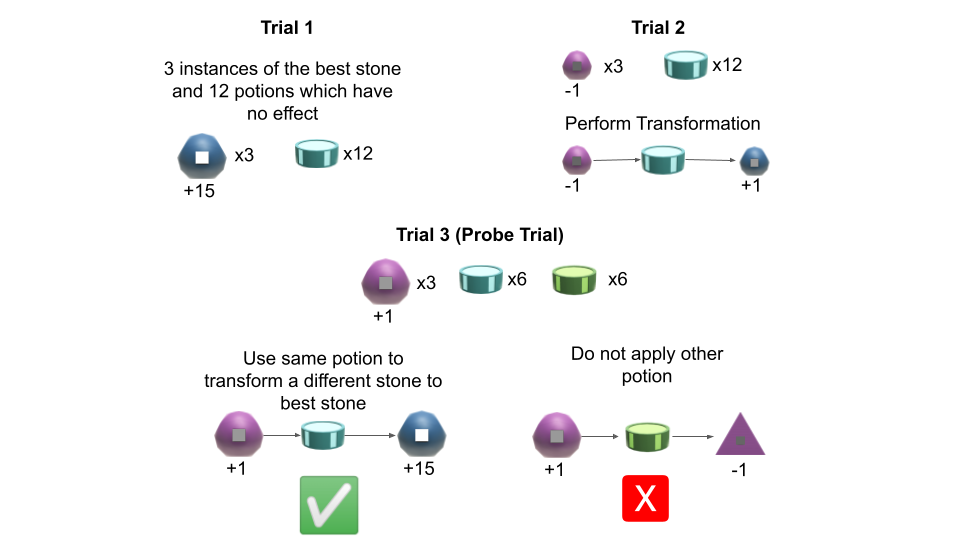

In [ ]:
#@title Potion Effect Different Stone Class
class potion_effect_different_stone:
  def __init__(self, add_belief_state=False):
    LatentPotion = stones_and_potions.LatentPotion
    LatentStone = stones_and_potions.LatentStone
    num_stones = 3

    mprobe_chemistry = utils.Chemistry(
      potion_map=stones_and_potions.all_fixed_potion_map(),
      stone_map=stones_and_potions.all_fixed_stone_map(),
      graph=graphs.create_graph_from_constraint(
          graphs.no_bottleneck_constraints()[0]),
      rotation=np.eye(3, dtype=np.int))
    mprobe_items = utils.EpisodeItems(
    stones=[
        [LatentStone(np.array([1, 1, 1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([-1, -1, 1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([-1, 1, 1], dtype=np.object))] * num_stones
    ],
    potions=[
        [LatentPotion(0, 1)] * 12,
        [LatentPotion(0, 1)] * 12,
        [LatentPotion(2, -1)] * 6 + [LatentPotion(0, 1)] * 6
    ])

    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
        chemistry=mprobe_chemistry, episode_items=mprobe_items)
    trackers = {
          symbolic_alchemy_trackers.AddMatrixEventTracker.NAME: 
              symbolic_alchemy_trackers.AddMatrixEventTracker(),
          symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
              symbolic_alchemy_trackers.ItemGeneratedTracker(),
          symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
              symbolic_alchemy_trackers.ItemsUsedTracker(),
          symbolic_alchemy_trackers.ScoreTracker.NAME: 
              symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
          }
    if add_belief_state:
      trackers[symbolic_alchemy_trackers.BeliefStateTracker.NAME] = symbolic_alchemy_trackers.BeliefStateTracker(precomp_maps, env)
    env.add_trackers(trackers)
    self.env = env

  def analyze_microprobe(self, episode_events):
    # check that on the third trial, the first potion type is used on all
    # stones, and the stones are then placed into the cauldron
    target_trial_event0 = ev_trk.OrderedEvents(
        [ev_trk.SingleEvent(0, set(range(6, 12))),
          ev_trk.SingleEvent(0, {-1})])
    target_trial_event1 = ev_trk.OrderedEvents(
        [ev_trk.SingleEvent(1, set(range(6, 12))),
          ev_trk.SingleEvent(1, {-1})])
    target_trial_event2 = ev_trk.OrderedEvents(
        [ev_trk.SingleEvent(2, set(range(6, 12))),
          ev_trk.SingleEvent(2, {-1})])
    target_happens = target_trial_event0.occurs(episode_events[2].events) and target_trial_event1.occurs(episode_events[2].events) and target_trial_event2.occurs(episode_events[2].events)
    # check that it does NOT use the other potion type
    foil_trial_event0 = ev_trk.SingleEvent(0, set(range(6)))
    foil_trial_event1 = ev_trk.SingleEvent(1, set(range(6)))
    foil_trial_event2 = ev_trk.SingleEvent(2, set(range(6)))
    foil_happens = foil_trial_event0.occurs(episode_events[2].events) or foil_trial_event1.occurs(episode_events[2].events) or foil_trial_event2.occurs(episode_events[2].events)
    event_score = int(target_happens and not foil_happens)

    return event_score

In [ ]:
#@title Run models through microprobe
peds_mp_scores = {}
peds_mp = potion_effect_different_stone()
num_samples = 20
greedy = False

#model free
beta = 9
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_modelfree(peds_mp.env, beta, greedy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(peds_mp.analyze_microprobe(episode_events))
peds_mp_scores['modelfree'] = event_score

#level k
beta = 9
gamma = 0.65
for sophistication_level in range(4):
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk(peds_mp.env, beta, gamma, sophistication_level, greedy)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(peds_mp.analyze_microprobe(episode_events))
  peds_mp_scores['level'+str(sophistication_level)] = event_score

# random agent
random_policy = RandomAgent()
event_score = []
for i in range(num_samples):
  env, reward = run_mp_agent(peds_mp.env, random_policy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(peds_mp.analyze_microprobe(episode_events))
peds_mp_scores['random agent'] = event_score

#random heuristic
rh_bot = symbolic_alchemy_bots.RandomActionBot(peds_mp.env._reward_weights, peds_mp.env)
event_score = []
for i in range(num_samples):
  bot_returns = rh_bot.run_episode()
  episode_events = bot_returns['matrix_event']['event_tracker']
  event_score.append(peds_mp.analyze_microprobe(episode_events))
peds_mp_scores['random heuristic'] = event_score

#ideal observer
add_belief_state = True
peds_mp = potion_effect_different_stone(add_belief_state)
io_bot = symbolic_alchemy_bots.IdealObserverBot(peds_mp.env._reward_weights, precomp_maps, peds_mp.env, minimise_world_states=False)
bot_returns = io_bot.run_episode()
episode_events = bot_returns['matrix_event']['event_tracker']
event_score = peds_mp.analyze_microprobe(episode_events)
peds_mp_scores['ideal observer'] = event_score

df_peds = pd.DataFrame.from_dict(peds_mp_scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/di

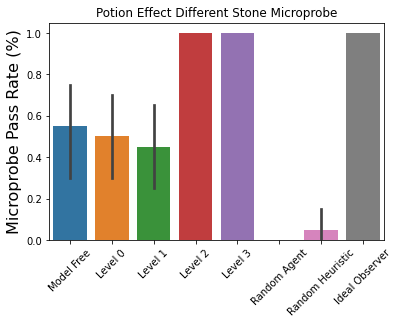

In [ ]:
#@title Plot Results
model_names = ['Model Free','Level 0','Level 1','Level 2','Level 3','Random Agent','Random Heuristic','Ideal Observer']

ax = sns.barplot(data=df_peds, ci=95)
plt.xticks(np.arange(len(model_names)), labels=model_names, rotation=45)
plt.ylabel('Microprobe Pass Rate (%)', fontsize=16)
plt.title('Potion Effect Different Stone Microprobe')
plt.show()

Models that can only learn about stone->potion effects from direct experience struggle on this microprobe and only pass by chance (model free, level 0, and level 1). Starting at sophistication level 2, the models can infer the effect a potion will have on a new stone based on the transformations it has previously observed. Thus, the knowledge they acquire about potion effects generalizes beyond the specific stones the potion was previously used on.

### Statistical Testing

For Potion Effect Different Stone, the Level 1 model is the best model that does not encode the knowledge being tested for. Therefore, we use the chance level performance from Level 1 as the null baseline for this microprobe.

How do the other models compare to the chance level performance of the null baseline? 

In [ ]:
#@title
model_strings = ['modelfree','level0','level2','level3','random heuristic','random agent']
zstat_list = []
reject_null = []

for model in model_strings:
  zstat, pval = compare_mp_distributions(peds_mp_scores, model, 'level1', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)

df_stats_peds = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = model_strings)
df_stats_peds

,modelfree,level0,level2,level3,random heuristic,random agent
ZStat,0.632,0.317,3.895,3.895,-2.921,-3.408
Reject Null,False,False,True,True,False,False


We see that Level 2 and Level 3 outperform the null baseline since they encode the inductive bias needed for this microprobe. Additionally, we see that the results from the Model Free and Level 0 agents are statistically indisguishable from Level 1.

How about a sophisticated model with various levels of noise?

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
for noise in noise_levels:
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk_plus_noise(peds_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(peds_mp.analyze_microprobe(episode_events))
  peds_mp_scores['level3 noise_'+str(noise)] = event_score

zstat_list = []
reject_null = []
keys = []

for noise in noise_levels:
  key = 'level3 noise_'+str(noise)
  zstat, pval = compare_mp_distributions(peds_mp_scores, key, 'level1', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)
  keys.append(key)

df_stats_peds_noise = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = keys)
df_stats_peds_noise

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)


,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
ZStat,1.936,0.317,-2.921,-3.408,-2.921
Reject Null,True,False,False,False,False


---
## Potion Effect 3 Trials Back

Test if agent can remember potion effect from trial 1 after using other potions in trials 2 and 3. 

*   First trial: observe potion effect (0,1) on stone (-1, -1, 1)
*   Second and third trial: observe potion effects of other two dimensions
*   Fourth trial: presented all potion types, remember to use potion (0,1) on stone (-1,1,1)

Microprobe test: Pass and score +1 if agent uses correct potion on new stone and avoids using other potions

**This microprobe tests if an agent has long-term memory beyond a handful of steps or 1-2 trials.**



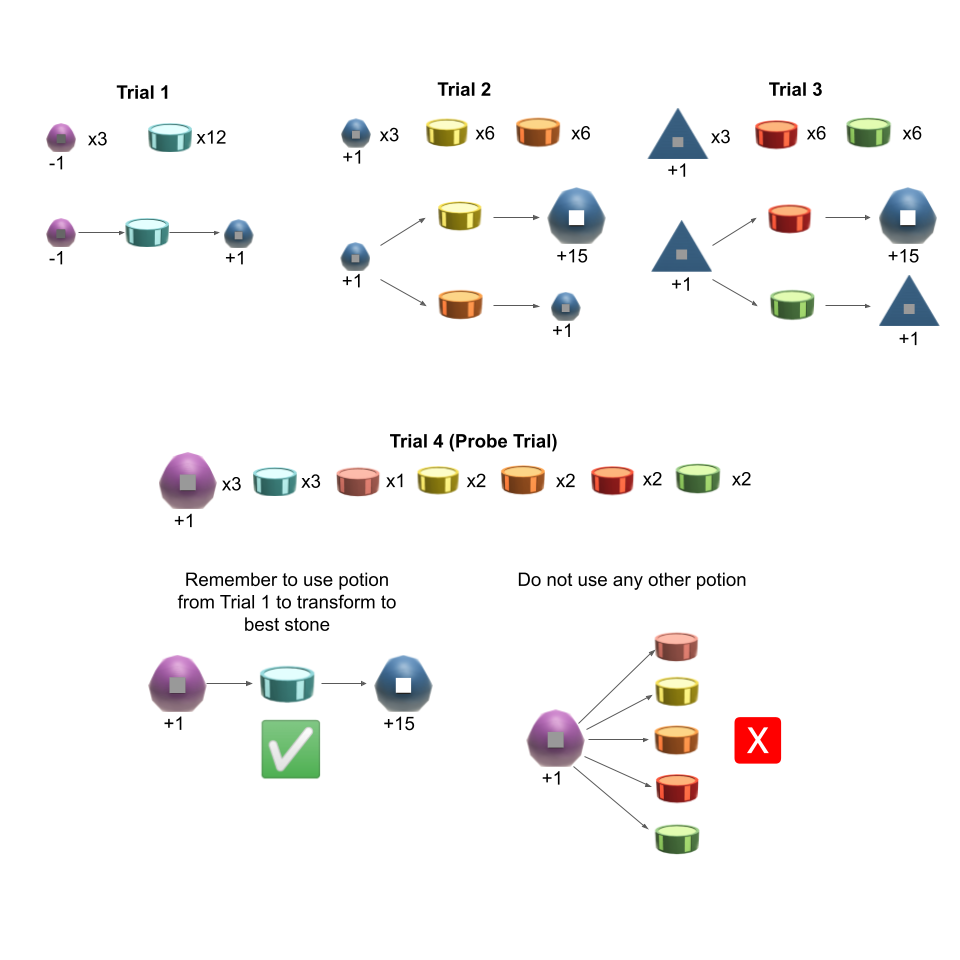

In [ ]:
#@title Potion Effect 3 Trials Back Class
class potion_effect_3trialsback:
  def __init__(self, add_belief_state=False):
    LatentPotion = stones_and_potions.LatentPotion
    LatentStone = stones_and_potions.LatentStone
    num_stones = 3

    mprobe_chemistry = utils.Chemistry(
      potion_map=stones_and_potions.all_fixed_potion_map(),
      stone_map=stones_and_potions.all_fixed_stone_map(),
      graph=graphs.create_graph_from_constraint(
          graphs.no_bottleneck_constraints()[0]),
      rotation=np.eye(3, dtype=np.int))
    mprobe_items = utils.EpisodeItems(
    stones=[
        [LatentStone(np.array([-1, -1, 1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([1, -1, 1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([1, 1, -1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([-1, 1, 1], dtype=np.object))] * num_stones
    ],
    potions=[
        [LatentPotion(0, 1)] * 12,
        [LatentPotion(1, 1)] * 6 + [LatentPotion(1, -1)] * 6,
        [LatentPotion(2, 1)] * 6 + [LatentPotion(2, -1)] * 6,
        [LatentPotion(0, 1)] * 3 + [LatentPotion(0, -1)] * 1 + [LatentPotion(1, 1)] * 2 + [LatentPotion(1, -1)] * 2 + [LatentPotion(2, 1)] * 2 + [LatentPotion(2, -1)] * 2
    ])

    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
        chemistry=mprobe_chemistry, episode_items=mprobe_items)
    trackers = {
          symbolic_alchemy_trackers.AddMatrixEventTracker.NAME: 
              symbolic_alchemy_trackers.AddMatrixEventTracker(),
          symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
              symbolic_alchemy_trackers.ItemGeneratedTracker(),
          symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
              symbolic_alchemy_trackers.ItemsUsedTracker(),
          symbolic_alchemy_trackers.ScoreTracker.NAME: 
              symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
          }
    if add_belief_state:
      trackers[symbolic_alchemy_trackers.BeliefStateTracker.NAME] = symbolic_alchemy_trackers.BeliefStateTracker(precomp_maps, env)
    env.add_trackers(trackers)
    self.env = env

  def analyze_microprobe(self, episode_events):
    # check that on the fourth trial, the first potion type is used on the
    # stones, and the stones are then placed into the cauldron
    target_happens = 0
    foil_happens = False
    for s_ind in range(3):
      target_trial_event = ev_trk.OrderedEvents(
          [ev_trk.SingleEvent(s_ind, set(range(3))),
            ev_trk.SingleEvent(s_ind, {-1})])
      target_happens += int(target_trial_event.occurs(episode_events[3].events))
      # check that it does NOT use the other potion types
      foil_trial_event = ev_trk.SingleEvent(s_ind, set(range(3, 12)))
      if foil_trial_event.occurs(episode_events[3].events):
        foil_happens = True
        break

    if target_happens == 3 and not foil_happens:
      event_score = 1
    else:
      event_score = 0

    return event_score

In [ ]:
#@title Run models through microprobe
pe3tb_mp_scores = {}
pe3tb_mp = potion_effect_3trialsback()
num_samples = 20
greedy = False

#model free
beta = 9
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_modelfree(pe3tb_mp.env, beta, greedy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(pe3tb_mp.analyze_microprobe(episode_events))
pe3tb_mp_scores['modelfree'] = event_score

#level k
beta = 9
gamma = 0.65
for sophistication_level in range(4):
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk(pe3tb_mp.env, beta, gamma, sophistication_level, greedy)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(pe3tb_mp.analyze_microprobe(episode_events))
  pe3tb_mp_scores['level'+str(sophistication_level)] = event_score

# random agent
random_policy = RandomAgent()
event_score = []
for i in range(num_samples):
  env, reward = run_mp_agent(pe3tb_mp.env, random_policy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(pe3tb_mp.analyze_microprobe(episode_events))
pe3tb_mp_scores['random agent'] = event_score

#random heuristic
rh_bot = symbolic_alchemy_bots.RandomActionBot(pe3tb_mp.env._reward_weights, pe3tb_mp.env)
event_score = []
for i in range(num_samples):
  bot_returns = rh_bot.run_episode()
  episode_events = bot_returns['matrix_event']['event_tracker']
  event_score.append(pe3tb_mp.analyze_microprobe(episode_events))
pe3tb_mp_scores['random heuristic'] = event_score

#ideal observer
add_belief_state = True
pe3tb_mp = potion_effect_3trialsback(add_belief_state)
io_bot = symbolic_alchemy_bots.IdealObserverBot(pe3tb_mp.env._reward_weights, precomp_maps, pe3tb_mp.env, minimise_world_states=False)
bot_returns = io_bot.run_episode()
event_score = int(bot_returns['score']['per_trial'][2] == 45)
pe3tb_mp_scores['ideal observer'] = event_score

df_pe3tb = pd.DataFrame.from_dict(pe3tb_mp_scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/di

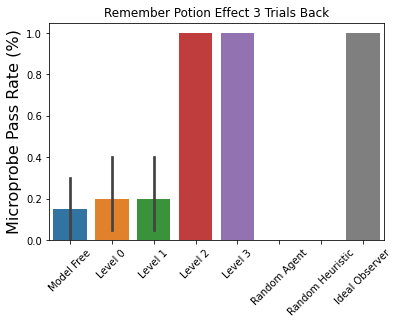

In [ ]:
#@title Plot Results
model_names = ['Model Free','Level 0','Level 1','Level 2','Level 3','Random Agent','Random Heuristic','Ideal Observer']

ax = sns.barplot(data=df_pe3tb, ci=95)
plt.xticks(np.arange(len(model_names)), labels=model_names, rotation=45)
plt.ylabel('Microprobe Pass Rate (%)', fontsize=16)
plt.title('Remember Potion Effect 3 Trials Back')
plt.show()

Similarly to the Potion Effect Different Stone microprobe, models that can only learn about stone->potion effects from direct experience struggle on this microprobe and only pass by chance (model free, level 0, and level 1). Levels 2 and 3 can infer a potion's effect on a new stone from prior experience with that potion. Additionally, these models retain knowledge throughout the entirety of an episode and therefore have the memory needed to remember a potion's effect from 3 trials back.

### Statistical Testing

Similarly to Potion Effect Different Stone, the Level 1 model is the best model that does not encode the knowledge being tested for in the Potion Effect 3 Trials Back microprobe. Therefore, we again use the chance level performance from Level 1 as the null baseline for this microprobe.

How do the other models compare to the chance level performance of the null baseline? 

In [ ]:
#@title
model_strings = ['modelfree','level0','level2','level3','random heuristic','random agent']
zstat_list = []
reject_null = []

for model in model_strings:
  zstat, pval = compare_mp_distributions(pe3tb_mp_scores, model, 'level1', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)

df_stats_pe3tb = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = model_strings)
df_stats_pe3tb

,modelfree,level0,level2,level3,random heuristic,random agent
ZStat,-0.416,0.0,5.164,5.164,-2.108,-2.108
Reject Null,False,False,True,True,False,False


We see that Level 2 and Level 3 outperform the null baseline since they encode the inductive bias needed for this microprobe. Additionally, we see that the results from the Model Free and Level 0 agents are not statistically different from Level 1.

How about a sophisticated model with various levels of noise?

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
for noise in noise_levels:
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk_plus_noise(pe3tb_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(pe3tb_mp.analyze_microprobe(episode_events))
  pe3tb_mp_scores['level3 noise_'+str(noise)] = event_score

zstat_list = []
reject_null = []
keys = []

for noise in noise_levels:
  key = 'level3 noise_'+str(noise)
  zstat, pval = compare_mp_distributions(pe3tb_mp_scores, key, 'level1', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)
  keys.append(key)

df_stats_pe3tb_noise = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = keys)
df_stats_pe3tb_noise

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)


,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
ZStat,1.989,1.989,-0.416,-2.108,-2.108
Reject Null,True,True,False,False,False


---
## Deduce Potion Pairs

Test if agent has knowledge about the potion pairings.

In first three trials, observe the effects of the negative potion in each dimension that transform stone from +1 to -1
  
  
On the fourth trial, use the information learned to deduce the effect of those potions' opposites and apply to the correct stones

Microprobe test: Pass and score +1 if all 3 stone-potion pairs correctly deduced

**This microprobe tests for an agent's capacity for structure learning, specifically probing whether it has knowledge of the potion pairs.**

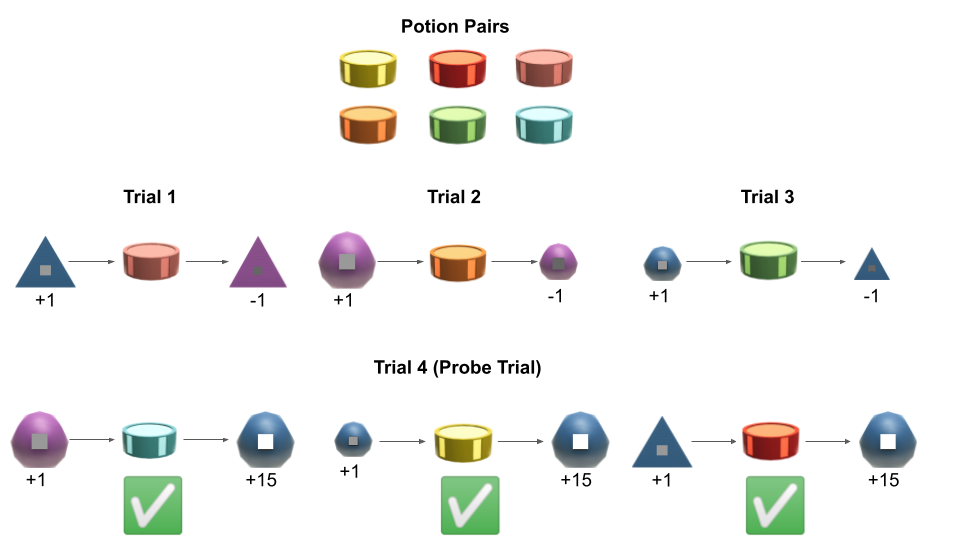

In [ ]:
#@title Deduce Potion Pairs Class
class deduce_potion_pairs:
  def __init__(self, add_belief_state=False):
    LatentPotion = stones_and_potions.LatentPotion
    LatentStone = stones_and_potions.LatentStone
    num_stones = 3

    mprobe_chemistry = utils.Chemistry(
      potion_map=stones_and_potions.all_fixed_potion_map(),
      stone_map=stones_and_potions.all_fixed_stone_map(),
      graph=graphs.create_graph_from_constraint(
          graphs.no_bottleneck_constraints()[0]),
      rotation=np.eye(3, dtype=np.int))
    mprobe_items = utils.EpisodeItems(
    stones=[
        [LatentStone(np.array([1, 1, -1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([-1, 1, 1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([1, -1, 1], dtype=np.object))] * num_stones,
        [LatentStone(np.array([-1, 1, 1], dtype=np.object)),
                LatentStone(np.array([1, -1, 1], dtype=np.object)),
                LatentStone(np.array([1, 1, -1], dtype=np.object))]
    ],
    potions=[
        [LatentPotion(0, -1)] * 12,
        [LatentPotion(1, -1)] * 12,
        [LatentPotion(2, -1)] * 12,
        [LatentPotion(0, 1)] * 4 + [LatentPotion(1, 1)] * 4 + [LatentPotion(2, 1)] * 4
    ])

    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
        chemistry=mprobe_chemistry, episode_items=mprobe_items)
    trackers = {
        symbolic_alchemy_trackers.AddMatrixEventTracker.NAME: 
            symbolic_alchemy_trackers.AddMatrixEventTracker(),
        symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
            symbolic_alchemy_trackers.ItemGeneratedTracker(),
        symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
            symbolic_alchemy_trackers.ItemsUsedTracker(),
        symbolic_alchemy_trackers.ScoreTracker.NAME: 
            symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
        }
    if add_belief_state:
      trackers[symbolic_alchemy_trackers.BeliefStateTracker.NAME] = symbolic_alchemy_trackers.BeliefStateTracker(precomp_maps, env)
    env.add_trackers(trackers)
    self.env = env

  def analyze_microprobe(self, episode_events):
    # check that on the fourth trial, the correct potions are used on each stone
    # score is % of stone-potion pairs correctly deduced
    event_score = 0
    all_potions = set(range(12))
    for s_ind in range(3):
      correct_potions = set(range((s_ind * 4), (s_ind * 4)+4))
      target_trial_event = ev_trk.OrderedEvents(
          [ev_trk.SingleEvent(s_ind, correct_potions),
            ev_trk.SingleEvent(s_ind, {-1})])
      target_happens = target_trial_event.occurs(episode_events[3].events)
      # check that it does NOT use the other potion types
      incorrect_potions = all_potions - correct_potions
      foil_trial_event = ev_trk.SingleEvent(s_ind, incorrect_potions)
      foil_happens = foil_trial_event.occurs(episode_events[3].events)

      if target_happens and not foil_happens:
        event_score += 1
    #event_score = event_score / 3
    event_score = int(event_score == 3)

    return event_score

In [ ]:
#@title Run models through microprobe
pp2_mp_scores = {}
pp2_mp = deduce_potion_pairs()
num_samples = 20
greedy = False

#model free
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_modelfree(pp2_mp.env, beta, greedy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(pp2_mp.analyze_microprobe(episode_events))
pp2_mp_scores['modelfree'] = event_score

#level k
for sophistication_level in range(4):
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk(pp2_mp.env, beta, gamma, sophistication_level, greedy)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(pp2_mp.analyze_microprobe(episode_events))
  pp2_mp_scores['level'+str(sophistication_level)] = event_score

# random agent
random_policy = RandomAgent()
event_score = []
for i in range(num_samples):
  env, reward = run_mp_agent(pp2_mp.env, random_policy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(pp2_mp.analyze_microprobe(episode_events))
pp2_mp_scores['random agent'] = event_score

#random heuristic
rh_bot = symbolic_alchemy_bots.RandomActionBot(pp2_mp.env._reward_weights, pp2_mp.env)
event_score = []
for i in range(num_samples):
  bot_returns = rh_bot.run_episode()
  episode_events = bot_returns['matrix_event']['event_tracker']
  event_score.append(pp2_mp.analyze_microprobe(episode_events))
pp2_mp_scores['random heuristic'] = event_score

#ideal observer
add_belief_state = True
pp2_mp = deduce_potion_pairs(add_belief_state)
io_bot = symbolic_alchemy_bots.IdealObserverBot(pp2_mp.env._reward_weights, precomp_maps, pp2_mp.env, minimise_world_states=False)
bot_returns = io_bot.run_episode()
episode_events = bot_returns['matrix_event']['event_tracker']
event_score = pp2_mp.analyze_microprobe(episode_events)
pp2_mp_scores['ideal observer'] = event_score

df_potionpairs = pd.DataFrame.from_dict(pp2_mp_scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/di

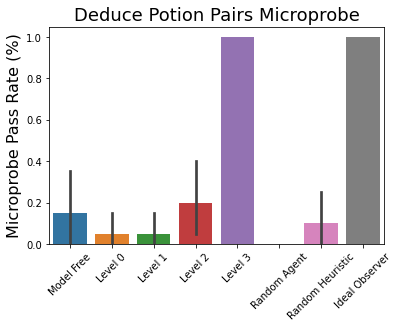

In [ ]:
#@title Plot Results
model_names = ['Model Free','Level 0','Level 1','Level 2','Level 3','Random Agent','Random Heuristic','Ideal Observer']

ax = sns.barplot(data=df_potionpairs, ci=95)
plt.xticks(np.arange(len(model_names)), labels=model_names, rotation=45)
plt.ylabel('Microprobe Pass Rate (%)', fontsize=16)
plt.title('Deduce Potion Pairs Microprobe', fontsize=18)
plt.show()

Only the models that encode the potion pairs structure are able to consistently solve this microprobe. The level 3 model in particular is able to infer a potion's effect after observing the effect of the opposite potion.

### Statistical Testing

The Level 2 model is the best model that does not encode knowledge about potion pairs. Therefore, we use the chance level performance from Level 2 as the null baseline for this microprobe.

How do the other models compare to the chance level performance of the null baseline?

In [ ]:
#@title
model_strings = ['modelfree','level0','level1','level3','random heuristic','random agent']
zstat_list = []
reject_null = []

for model in model_strings:
  zstat, pval = compare_mp_distributions(pp2_mp_scores, model, 'level2', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)

df_stats_pp2 = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = model_strings)
df_stats_pp2

,modelfree,level0,level1,level3,random heuristic,random agent
ZStat,-0.416,-1.434,-1.434,5.164,-0.886,-2.108
Reject Null,False,False,False,True,False,False


We see that only Level 3 outperforms the null baseline since it encodes the inductive bias about potion pairs needed for this microprobe.

How about a sophisticated model with various levels of noise?

In [ ]:
#@title
# level k
beta = 9
gamma = 0.65
greedy = False
sophistication_level = 3
noise_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
for noise in noise_levels:
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk_plus_noise(pp2_mp.env, beta, gamma, sophistication_level, greedy, noise)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(pp2_mp.analyze_microprobe(episode_events))
  pp2_mp_scores['level3 noise_'+str(noise)] = event_score

zstat_list = []
reject_null = []
keys = []

for noise in noise_levels:
  key = 'level3 noise_'+str(noise)
  zstat, pval = compare_mp_distributions(pp2_mp_scores, key, 'level2', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)
  keys.append(key)

df_stats_pp2_noise = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = keys)
df_stats_pp2_noise

/usr/local/lib/python3.7/dist-packages/dm_alchemy/ideal_observer/ideal_observer.py:585: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.world_state_distribution.new_trial(aligned_stones)


,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
ZStat,3.178,1.989,-0.886,-2.108,-2.108
Reject Null,True,True,False,False,False


---
## Plan Around Bottleneck

Test if agent can plan around bottleneck

To transform (1, -1, 1) stone to best stone (1, 1, 1), agent needs to sequence together 3 transformations due to a bottleneck at the edge between (1, -1, 1) and (1, 1, 1). The correct sequence is Stone(1, -1, 1) -> Potion(2, -1), Stone(1, -1, -1) -> Potion(1, 1) -> Stone(1, 1, -1) -> Potion(2, 1) = Stone(1, 1, 1)

Crucially, the agent has to reduce the value of the stone in the first step of this sequence. Agents that act greedily will therefore fail, while agents that can plan multiple steps ahead can solve this microprobe.

1.   Trial 1: Agent presented with two (1, -1, 1) stones and one (1, -1, -1) stone along with six potions of (2, -1) and (1, 1) each. Agent can observe Stone(1, -1, 1) -> Potion(2, -1) = Stone(1, -1, -1) and Stone(1, -1, -1) -> Potion(1, 1) = Stone(1, 1, -1) transformations. Additionally, the agent can recognize the presence of a bottleneck preventing a transformation happening with Stone(1, -1, 1) -> Potion(1, 1).
2.   Trial 2: Agent presented with three (1, 1, -1) stones and 12 (2, 1) potions. Agent can observe these stones turning into the best stone with the transformation Stone(1, 1, -1) -> Potion(2, 1) = Stone(1, 1, 1).
3.   Trial 3: Agent presented with three (1, -1, 1) stones and all three potions types from the previous two trials. Agent has to integrate the information learned in the previous trials to plan around the bottleneck and sequence together the correct transformations to make the best stones. There is very little room for experimentation and an agent will not receive a perfect score of 45 on this trial if potions are wasted.

Microprobe test: Pass and score +1 if agent gets transforms all three stones to +15 stones on Trial 3 (getting +45 reward)

**This microprobe tests if an agent is able to plan multiple steps in the future.**

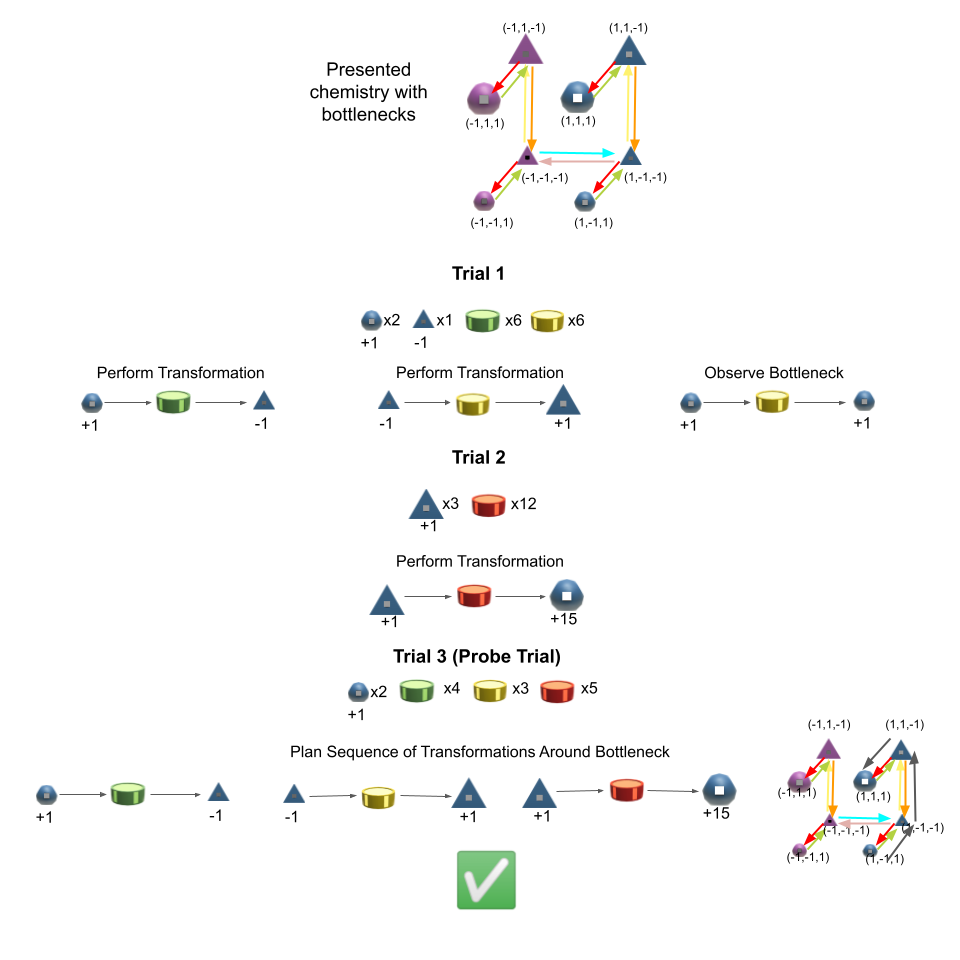

In [ ]:
#@title Plan Around Bottleneck Class
class plan_around_bottleneck:
  def __init__(self, add_belief_state=False):
    LatentPotion = stones_and_potions.LatentPotion
    LatentStone = stones_and_potions.LatentStone
    num_stones = 3

    mprobe_chemistry = utils.Chemistry(
      potion_map=stones_and_potions.all_fixed_potion_map(),
      stone_map=stones_and_potions.all_fixed_stone_map(),
      graph=graphs.create_graph_from_constraint(
         [['X', '1', '-1'], ['*', 'X', '-1'], ['*', '*', 'X']]),
      rotation=np.eye(3, dtype=np.int))
    mprobe_items = utils.EpisodeItems(
    stones=[
        # trial 1
        [LatentStone(np.array([1, -1, 1], dtype=np.object)), 
         LatentStone(np.array([1, -1, 1], dtype=np.object)), 
         LatentStone(np.array([1, -1, -1], dtype=np.object))],
        # trial 2
        [LatentStone(np.array([1, 1, -1], dtype=np.object))] * num_stones,
        # trial 3
        [LatentStone(np.array([1, -1, 1], dtype=np.object))] * num_stones
    ],
    potions=[
        [LatentPotion(2, -1)] * 6 + [LatentPotion(1, 1)] * 6,
        [LatentPotion(2, 1)] * 12,
        [LatentPotion(2, -1)] * 4 + [LatentPotion(1, 1)] * 3 + [LatentPotion(2, 1)] * 5
    ])

    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
        chemistry=mprobe_chemistry, episode_items=mprobe_items)
    trackers = {
          symbolic_alchemy_trackers.AddMatrixEventTracker.NAME: 
              symbolic_alchemy_trackers.AddMatrixEventTracker(),
          symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
              symbolic_alchemy_trackers.ItemGeneratedTracker(),
          symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
              symbolic_alchemy_trackers.ItemsUsedTracker(),
          symbolic_alchemy_trackers.ScoreTracker.NAME: 
              symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
          }
    if add_belief_state:
      trackers[symbolic_alchemy_trackers.BeliefStateTracker.NAME] = symbolic_alchemy_trackers.BeliefStateTracker(precomp_maps, env)
    env.add_trackers(trackers)
    self.env = env

In [ ]:
#@title Run models through microprobe
plan_mp_scores = {}
plan_mp = plan_around_bottleneck()
num_samples = 20
greedy = False

#model free
event_score = []
for i in range(num_samples):
  env, traj, reward = run_mp_modelfree(plan_mp.env, beta, greedy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(int(env.episode_returns()['score']['per_trial'][2] == 45))
plan_mp_scores['modelfree'] = event_score

#level k
for sophistication_level in range(4):
  event_score = []
  for i in range(num_samples):
    env, traj, reward = run_mp_model_levelk(plan_mp.env, beta, gamma, sophistication_level, greedy)
    episode_events = env.events()['matrix_event']['event_tracker']
    event_score.append(int(env.episode_returns()['score']['per_trial'][2] == 45))
  plan_mp_scores['level'+str(sophistication_level)] = event_score

# random agent
random_policy = RandomAgent()
event_score = []
for i in range(num_samples):
  env, reward = run_mp_agent(plan_mp.env, random_policy)
  episode_events = env.events()['matrix_event']['event_tracker']
  event_score.append(int(env.episode_returns()['score']['per_trial'][2] == 45))
plan_mp_scores['random agent'] = event_score

#random heuristic
rh_bot = symbolic_alchemy_bots.RandomActionBot(plan_mp.env._reward_weights, plan_mp.env)
event_score = []
for i in range(num_samples):
  bot_returns = rh_bot.run_episode()
  episode_events = bot_returns['matrix_event']['event_tracker']
  event_score.append(int(bot_returns['score']['per_trial'][2] == 45))
plan_mp_scores['random heuristic'] = event_score

#ideal observer
add_belief_state = True
plan_mp = plan_around_bottleneck(add_belief_state)
io_bot = symbolic_alchemy_bots.IdealObserverBot(plan_mp.env._reward_weights, precomp_maps, plan_mp.env, minimise_world_states=False)
bot_returns = io_bot.run_episode()
episode_events = bot_returns['matrix_event']['event_tracker']
event_score = int(bot_returns['score']['per_trial'][2] == 45)
plan_mp_scores['ideal observer'] = event_score

df_plan = pd.DataFrame.from_dict(plan_mp_scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

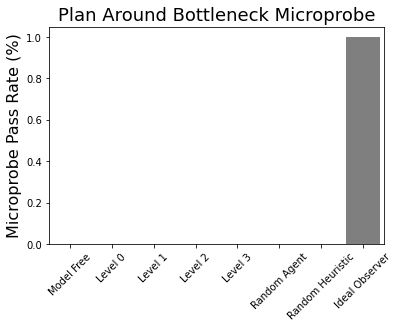

In [ ]:
#@title Plot Results
model_names = ['Model Free','Level 0','Level 1','Level 2','Level 3','Random Agent','Random Heuristic','Ideal Observer']

ax = sns.barplot(data=df_plan, ci=95)
plt.xticks(np.arange(len(model_names)), labels=model_names, rotation=45)
plt.ylabel('Microprobe Pass Rate (%)', fontsize=16)
plt.title('Plan Around Bottleneck Microprobe', fontsize=18)
plt.show()

Only the ideal observer passes this microprobe because it is the only model with the ability to simulate mulitple steps in the future. The model free and model based actions will select actions greedily and refrain from using a potion that will reduce the value of the stone, even though this step is necessary to transform it into a gold stone in three steps. 

### Statistical Testing

The Level 3 model is the best model that does not have the capacity for planning. Therefore, we use the chance level performance from Level 3 as the null baseline for this microprobe.

How do the other models compare to the chance level performance of the null baseline?

In [ ]:
#@title
model_strings = ['modelfree','level0','level1','level2','random heuristic','random agent']
zstat_list = []
reject_null = []

for model in model_strings:
  zstat, pval = compare_mp_distributions(plan_mp_scores, model, 'level3', alternative='larger')
  zstat_list.append(round(zstat,3))
  reject_null.append(pval < 0.05)

df_stats_plan = pd.DataFrame([zstat_list,reject_null], index = ['ZStat','Reject Null'], columns = model_strings)
df_stats_plan

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,modelfree,level0,level1,level2,random heuristic,random agent
ZStat,0.0,0.0,0.0,0.0,0.0,0.0
Reject Null,False,False,False,False,False,False


Since none of the models ever pass the Microprobe, they are not statistically better than the null baseline.

## Summary Stats

Overall which models outperformed the null baseline model (P < 0.05) for each microprobe? 

In [ ]:
#@title
df_stats_list = [df_stats_gold, df_stats_avs, df_stats_abp, df_stats_pess, df_stats_one_shot, df_stats_peds, df_stats_pe3tb, df_stats_pp2, df_stats_plan]
summary_stats = {}

model = 'modelfree'
summary_stats[model] = []
for df in df_stats_list:
  summary_stats[model].append(df.loc['Reject Null',model])

model = 'level0'
summary_stats[model] = []
for df in df_stats_list:
  summary_stats[model].append(df.loc['Reject Null',model])

model = 'level1'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num == 5 or mp_num == 6:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['Reject Null',model])

model = 'level2'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num == 7:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['Reject Null',model])

model = 'level3'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num == 8:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['Reject Null',model])

model = 'random heuristic'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num == 3 or mp_num == 4:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['Reject Null',model])

model = 'random agent'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num < 3:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['Reject Null',model])

model = 'ideal observer'
summary_stats[model] = [True for i in range(len(df_stats_list))]

mp_names = ['Put Gold Stone','All Value Stones','Avoid Bad Potions','Potion Effect Same Stone','One Shot Learning','Potion Effect Different Stone',
            'Potion Effect 3 Trials Back','Deduce Potion Pairs','Plan Around Bottleneck']
df_summary_stats_reject = pd.DataFrame.from_dict(summary_stats)
df_summary_stats_reject.index = mp_names
df_summary_stats_reject

,modelfree,level0,level1,level2,level3,random heuristic,random agent,ideal observer
Put Gold Stone,True,True,True,True,True,True,Null Model,True
All Value Stones,True,True,True,True,True,True,Null Model,True
Avoid Bad Potions,True,True,True,True,True,False,Null Model,True
Potion Effect Same Stone,True,True,True,True,True,Null Model,False,True
One Shot Learning,True,True,True,True,True,Null Model,False,True
Potion Effect Different Stone,False,False,Null Model,True,True,False,False,True
Potion Effect 3 Trials Back,False,False,Null Model,True,True,False,False,True
Deduce Potion Pairs,False,False,False,Null Model,True,False,False,True
Plan Around Bottleneck,False,False,False,False,Null Model,False,False,True


What were the Z-Statistics for the comparisons to the null baseline models?

In [ ]:
#@title
df_stats_list = [df_stats_gold, df_stats_avs, df_stats_abp, df_stats_pess, df_stats_one_shot, df_stats_peds, df_stats_pe3tb, df_stats_pp2, df_stats_plan]
summary_stats = {}

model = 'modelfree'
summary_stats[model] = []
for df in df_stats_list:
  summary_stats[model].append(df.loc['ZStat',model])

model = 'level0'
summary_stats[model] = []
for df in df_stats_list:
  summary_stats[model].append(df.loc['ZStat',model])

model = 'level1'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num == 5 or mp_num == 6:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['ZStat',model])

model = 'level2'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num == 7:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['ZStat',model])

model = 'level3'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num == 8:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['ZStat',model])

model = 'random heuristic'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num == 3 or mp_num == 4:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['ZStat',model])

model = 'random agent'
summary_stats[model] = []
for mp_num, df in enumerate(df_stats_list):
  if mp_num < 3:
    summary_stats[model].append('Null Model')
  else:
    summary_stats[model].append(df.loc['ZStat',model])

mp_names = ['Put Gold Stone','All Value Stones','Avoid Bad Potions','Potion Effect Same Stone','One Shot Learning','Potion Effect Different Stone',
            'Potion Effect 3 Trials Back','Deduce Potion Pairs','Plan Around Bottleneck']
df_summary_stats_zstat = pd.DataFrame.from_dict(summary_stats)
df_summary_stats_zstat.index = mp_names
df_summary_stats_zstat

,modelfree,level0,level1,level2,level3,random heuristic,random agent
Put Gold Stone,6.325,6.325,6.325,6.325,6.325,6.325,Null Model
All Value Stones,6.325,6.325,6.325,6.325,6.325,6.325,Null Model
Avoid Bad Potions,6.325,6.325,6.325,6.325,6.325,0.0,Null Model
Potion Effect Same Stone,6.016,6.016,6.016,6.016,6.016,Null Model,-1.013
One Shot Learning,3.162,2.191,3.162,3.162,3.162,Null Model,-2.939
Potion Effect Different Stone,0.632,0.317,Null Model,3.895,3.895,-2.921,-3.408
Potion Effect 3 Trials Back,-0.416,0.000,Null Model,5.164,5.164,-2.108,-2.108
Deduce Potion Pairs,-0.416,-1.434,-1.434,Null Model,5.164,-0.886,-2.108
Plan Around Bottleneck,0.000,0.000,0.0,0.0,Null Model,0.0,0.0


And the Noisy Level 3 agents

In [ ]:
#@title
df_stats_list = [df_stats_gold_noise, df_stats_avs_noise, df_stats_abp_noise, 
                 df_stats_pess_noise, df_stats_one_shot_noise, df_stats_peds_noise, 
                 df_stats_pe3tb_noise, df_stats_pp2_noise]
summary_stats = {}

for model in df_stats_gold_noise.keys():
  summary_stats[model] = []
  for df in df_stats_list:
    summary_stats[model].append(df.loc['Reject Null',model])

mp_names = ['Put Gold Stone','All Value Stones','Avoid Bad Potions','Potion Effect Same Stone','One Shot Learning','Potion Effect Different Stone',
            'Potion Effect 3 Trials Back','Deduce Potion Pairs']
df_summary_stats_reject_noise = pd.DataFrame.from_dict(summary_stats)
df_summary_stats_reject_noise.index = mp_names
df_summary_stats_reject_noise

,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
Put Gold Stone,True,True,False,False,False
All Value Stones,True,True,True,True,False
Avoid Bad Potions,True,True,True,False,False
Potion Effect Same Stone,True,True,False,False,False
One Shot Learning,True,True,False,False,False
Potion Effect Different Stone,True,False,False,False,False
Potion Effect 3 Trials Back,True,True,False,False,False
Deduce Potion Pairs,True,True,False,False,False


In [ ]:
#@title
df_stats_list = [df_stats_gold_noise, df_stats_avs_noise, df_stats_abp_noise, 
                 df_stats_pess_noise, df_stats_one_shot_noise, df_stats_peds_noise, 
                 df_stats_pe3tb_noise, df_stats_pp2_noise]
summary_stats = {}

for model in df_stats_gold_noise.keys():
  summary_stats[model] = []
  for df in df_stats_list:
    summary_stats[model].append(df.loc['ZStat',model])

mp_names = ['Put Gold Stone','All Value Stones','Avoid Bad Potions','Potion Effect Same Stone','One Shot Learning','Potion Effect Different Stone',
            'Potion Effect 3 Trials Back','Deduce Potion Pairs']
df_summary_stats_zstat_noise = pd.DataFrame.from_dict(summary_stats)
df_summary_stats_zstat_noise.index = mp_names
df_summary_stats_zstat_noise

,level3 noise_0.1,level3 noise_0.25,level3 noise_0.5,level3 noise_0.75,level3 noise_0.9
Put Gold Stone,5.721,3.162,1.451,1.013,0.000
All Value Stones,5.437,4.899,3.162,2.390,1.451
Avoid Bad Potions,4.899,3.408,2.657,1.451,1.013
Potion Effect Same Stone,3.978,2.921,0.000,-1.013,-1.013
One Shot Learning,3.162,1.771,0.327,0.663,-1.265
Potion Effect Different Stone,1.936,0.317,-2.921,-3.408,-2.921
Potion Effect 3 Trials Back,1.989,1.989,-0.416,-2.108,-2.108
Deduce Potion Pairs,3.178,1.989,-0.886,-2.108,-2.108


# Discussion

In this colab we have introduced microprobes, which are test episodes that evaluate the levels of knowledge that agents possess about the Alchemy task structure. By testing agents that employ learning strategies at progressive levels of complexity, we have demonstrated how microprobes can be used to assess what specific aspects about the task structure trained agents have meta-learned. Agents that do not understand the meaning of the reward dimension in the state space will fail Put Gold Stone and All Value Stones. Agents that do not understand the function of the potions will fail Avoid Bad Potions. Additionally, agents that do not have the capacity to learn within an episode or maintain memory, such as ones with purely feedforward architectures, will fail Avoid Bad Potions, Potion Effect Same Stone, and higher level microprobes. One Shot Learning and Potion Effect Different Stone further probe whether agents that learn within an episode can generalize their learned knowledge to a new instance or new stone respectively. At this level, we begin to see our models diverge in performance, as the models that only learn from direct experience begin to struggle on Potion Effect Different Stone (model free, level 0, and level 1). Potion Effect 3 trials back tests if an agent has long-term memory beyond a handful of steps or 1-2 trials, which may challenge agents whose memory degrades with each time step, such as agents with RNN memory. Deduce Potion Pairs examines whether an agent understands that potions come in pairs with opposite effects, which is challenging to meta-learn de novo with baseline deep RL agents. Only the level 3 model, that incorporates knowledge about the potion pairs, solves this microprobe at the level of the ideal observer. Lastly, Plan Around Bottleneck stumps all of the models other than the ideal observer, as it requires multistep planning and knowledge about bottlenecks. 

These microprobes test for the learning of abstractions in a hierarchical way, once an agent learns a lower-level abstraction, it affords them the capacity to learn higher-level abstractions on top of it, analogously to human development and schema formation. Therefore, these analysis tools can also be used to characterize how an agent learns these abstractions across a learning trajectory. This opens up exciting research questions such as: when does knowledge of these concepts appear during training, and how does this developmental trajectory change with different architectures, objective functions, and training regimes. 

# Contact

For additional information, contact Logan Cross: locross93@gmail.com

Website: https://locross93.github.io/

# Related Resources

Alchemy paper: https://arxiv.org/abs/2102.02926

Alchemy github: https://github.com/deepmind/dm_alchemy

Alchemy tutorial: https://colab.research.google.com/github/deepmind/dm_alchemy/blob/master/examples/AlchemyGettingStarted.ipynb

# References



1.   Daw, N. D. (2011). Trial-by-trial data analysis using computational models. Decision making, affect, and learning: Attention and performance XXIII, 23(1).
2.   O'Doherty, J. P., Dayan, P., Friston, K., Critchley, H., & Dolan, R. J. (2003). Temporal difference models and reward-related learning in the human brain. Neuron, 38(2), 329-337.
3.   Daw, N. D., & Tobler, P. N. (2014). Value learning through reinforcement: the basics of dopamine and reinforcement learning. In Neuroeconomics (pp. 283-298). Academic Press.
4.   Wilson, R. C., & Collins, A. G. (2019). Ten simple rules for the computational modeling of behavioral data. Elife, 8, e49547.
5.   Computational modeling tutorial: http://www.hannekedenouden.ruhosting.nl/RLtutorial/Instructions.html 
6.   Dickinson, A. (1985). Actions and habits: the development of behavioural autonomy. Philosophical Transactions of the Royal Society of London. B, Biological Sciences, 308(1135), 67-78.
7.   Doll, B. B., Simon, D. A., & Daw, N. D. (2012). The ubiquity of model-based reinforcement learning. Current opinion in neurobiology, 22(6), 1075-1081.
8.   Daw, N. D., & O’Doherty, J. P. (2014). Multiple systems for value learning. In Neuroeconomics (pp. 393-410). Academic Press.

